In [1]:
import xarray as xr
# open the 'LGMR_GMST_ens.nc' file
ds_sat = xr.open_dataset('data/LGMR_SAT_climo.nc')
ds_sat

c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\xarray\coding\variables.py:148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, age: 120)
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * age      (age) float32 100.0 300.0 500.0 ... 2.35e+04 2.37e+04 2.39e+04
Data variables:
    sat      (age, lat, lon) float32 ...
    sat_std  (age, lat, lon) float32 ...

In [16]:
#########################################################################################################
import matplotlib.pyplot as plt

def plot_pc(pca_temp_df, ds_cleaned, v_exp_temp,reversed=False):
    # Create a figure with a single subplot
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=300)

    # Loop through all the PCs and plot them for temperature
    for i in range(pca_temp_df.shape[1]):
        # Plot the i-th PC for temperature
        if i==0:
            axes.plot(ds_cleaned['age'],pca_temp_df[f'pc {i+1}']*-1,  label=f'PC {i+1}, v:{v_exp_temp[i]:.2f}')
        else:
            axes.plot(ds_cleaned['age'],pca_temp_df[f'pc {i+1}'],  label=f'PC {i+1}, v:{v_exp_temp[i]:.2f}')
        axes.set_title('Temperature')
        axes.set_xlabel('PC Values')
        axes.set_ylabel('Age (yr BP)')
    if reversed:
        # reverse the y axis
        axes.invert_yaxis()
    # axes.invert_yaxis()
    axes.legend()

    # Show the figure
    plt.show()


########################################################################################################

import matplotlib.pyplot as plt
import numpy as np

def plot_score(temp_score):
    # plot the histogram of temp_score
    plt.figure(figsize=(8, 6),dpi=300)
    plt.hist(temp_score[:,0], bins=50)
    plt.hist(temp_score[:,1], bins=50)
    # add legend
    plt.legend(['PC1', 'PC2'])
    # add title
    plt.title('Histogram of the score of SAT on PC1 and PC2')
    # add xlabel
    plt.xlabel('Score')
    # add ylabel
    plt.ylabel('Count')
    plt.show()
    # n_cols = temp_score.shape[1]  # number of principal components
    # fig, axs = plt.subplots(ncols=n_cols, figsize=(15, 8), dpi=300)

    # for i in range(n_cols):
    #     axs[i].hist(temp_score[:, i], bins=100, density=True)
    #     axs[i].set_xlim(np.quantile(temp_score, 0.001), np.quantile(temp_score, 0.999))
    #     axs[i].set_title(f'PC{i+1}')
    #     axs[i].set_xlabel('Temperature score')
    #     axs[i].set_ylabel('Probability density')

    # plt.tight_layout()
    # plt.show()

########################################################################################################

# do the pca
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import zscore

def pca_score(temp_scaled, ds, n_pc=2, reversed=False, if_zscore=False):


    # pca
    pca_T = PCA(n_components=n_pc)
    columns = [f'pc {i}' for i in range(1, n_pc+1)]

    pca_temp = pca_T.fit_transform(temp_scaled)
    pca_temp_df = pd.DataFrame(data=pca_temp, columns=columns)

    if if_zscore:
        temp_score = temp_scaled.T.dot(zscore(pca_temp))
    else:
        temp_score = temp_scaled.T.dot(pca_temp)

    v_exp_temp = pca_T.explained_variance_ratio_
    
    print(f'variation explained by PC1 and PC2 for temperature: {v_exp_temp}')

    plot_pc(pca_temp_df, ds, v_exp_temp, reversed=reversed)
    plot_score(temp_score)
    
    return temp_score

In [18]:

import numpy as np
import xarray as xr

def center_data(ds_sat, variable_name):
    """
    Center the specified variable in the given dataset by subtracting its mean.

    Parameters:
    - dataset (xarray.Dataset): The dataset containing the variable to be centered.
    - variable_name (str): The name of the variable to be centered.

    Returns:
    - centered_dataset (xarray.Dataset): The dataset with the centered variable added as a new variable.
    """
    # Calculate the mean along the 'age' axis
    mean_data = ds_sat[variable_name].mean(dim='age')

    # Subtract the mean from the data
    centered_data = ds_sat[variable_name] - mean_data

    # Add the centered_data as a new variable in the dataset
    centered_dataset = ds_sat.assign(**{f'{variable_name}_centered': centered_data})

    return centered_dataset






import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import zscore
import numpy as np
from sklearn.mixture import GaussianMixture
import xarray as xr
import matplotlib.pyplot as plt

def GMM_test(temp_score, ds_sat, n_components=5):
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    sat_scores = temp_score
    sat_shape = ds_sat['sat'].shape

    # create a 2D GMM model
    gmm_model = GaussianMixture(n_components=n_components, covariance_type='full')

    # fit the model to the two columns of PCA scores
    gmm_model.fit(sat_scores)

    # get the predicted class labels for each data point
    class_labels = gmm_model.predict(sat_scores)

    # add the class labels to the xarray dataset
    ds_sat['class_label'] = (('lat', 'lon'), class_labels.reshape(sat_shape[1], sat_shape[2]))

    # plot the results
    fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=300)

    # plot the scatter plot of the two columns
    for i in range(n_components):
        mask = class_labels == i
        ax[0].scatter(sat_scores[:, 0][mask], sat_scores[:, 1][mask], s=10, alpha=0.5, color=colors[i])

    # plot the contour plot of the fitted GMM
    x, y = np.meshgrid(np.linspace(np.min(sat_scores[:, 0]), np.max(sat_scores[:, 0]), 100),
                       np.linspace(np.min(sat_scores[:, 1]), np.max(sat_scores[:, 1]), 100))
    XX = np.array([x.ravel(), y.ravel()]).T
    Z = -gmm_model.score_samples(XX)
    Z = Z.reshape(x.shape)
    ax[1].contour(x, y, Z, cmap='coolwarm_r')

    # Add labels and title
    ax[0].set_xlabel('PC 1')
    ax[0].set_ylabel('PC 2')
    ax[1].set_xlabel('PC 1')
    ax[1].set_ylabel('PC 2')
    ax[0].set_title('Scatter plot of PCA scores')
    ax[1].set_title('Contour plot of fitted GMM')

    plt.tight_layout()
    plt.show()


In [4]:
ds_sat=center_data(ds_sat, 'sat')

c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\xarray\coding\variables.py:148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


In [11]:
weight = np.cos(np.deg2rad(ds_sat['lat']))


# set weight to 0 if it is smaller than 0
weight = xr.where(weight < 0, 0, weight)


# Multiply 'sat_anomalies' with the weight
sat_anomalies_weighted = ds_sat['sat_centered'] * weight

# Add 'sat_anomalies_weighted' as a new data variable in the dataset
ds_sat['sat_centered_weighted'] = sat_anomalies_weighted

sat_centered_weighted = ds_sat['sat_centered_weighted'].values
sat_centered_weighted = sat_centered_weighted.reshape(120, 96*144)


In [37]:
sat = ds_sat['sat'].values
sat.shape
# reshape the sat to a 2D array
sat = sat.reshape(120, 96*144)
sat=sat.T

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sat_spatial_normalized = scaler.fit_transform(sat)
print(sat_spatial_normalized.shape)

# calculate the mean of each row
sat_spatial_normalized_rowmean = np.mean(sat_spatial_normalized, axis=1)
print(sat_spatial_normalized_rowmean.shape)

# subtract the mean of each row from each element in the row
sat_spatial_normalized_centered = sat_spatial_normalized - sat_spatial_normalized_rowmean[:, np.newaxis]
print(sat_spatial_normalized_centered.shape)


(13824, 120)
(13824,)
(13824, 120)


In [67]:
weight = np.cos(np.deg2rad(ds_sat['lat']))
weight = xr.where(weight < 0, 0, weight)
print(weight.shape)

# make an empty array with size 96*144
weight_reshaped = np.zeros([96,144])
print(weight_reshaped.shape)

# let each column of the array be the weight
for i in range(144):
    weight_reshaped[:,i] = weight


# reshape the weight to 96*144
weight_reshaped = weight_reshaped.reshape(96*144)
print(weight_reshaped.shape)


(96,)
(96, 144)
(13824,)


In [69]:
# each row of the sat_spatial_normalized_centered_weighted times the weight
sat_spatial_normalized_centered_weighted = sat_spatial_normalized_centered 

for i in range (len(weight_reshaped)):
    sat_spatial_normalized_centered_weighted[i,:] = sat_spatial_normalized_centered[i,:] * weight_reshaped[i]

print(sat_spatial_normalized_centered_weighted.shape)


(13824, 120)


variation explained by PC1 and PC2 for temperature: [0.9617764  0.02574337]


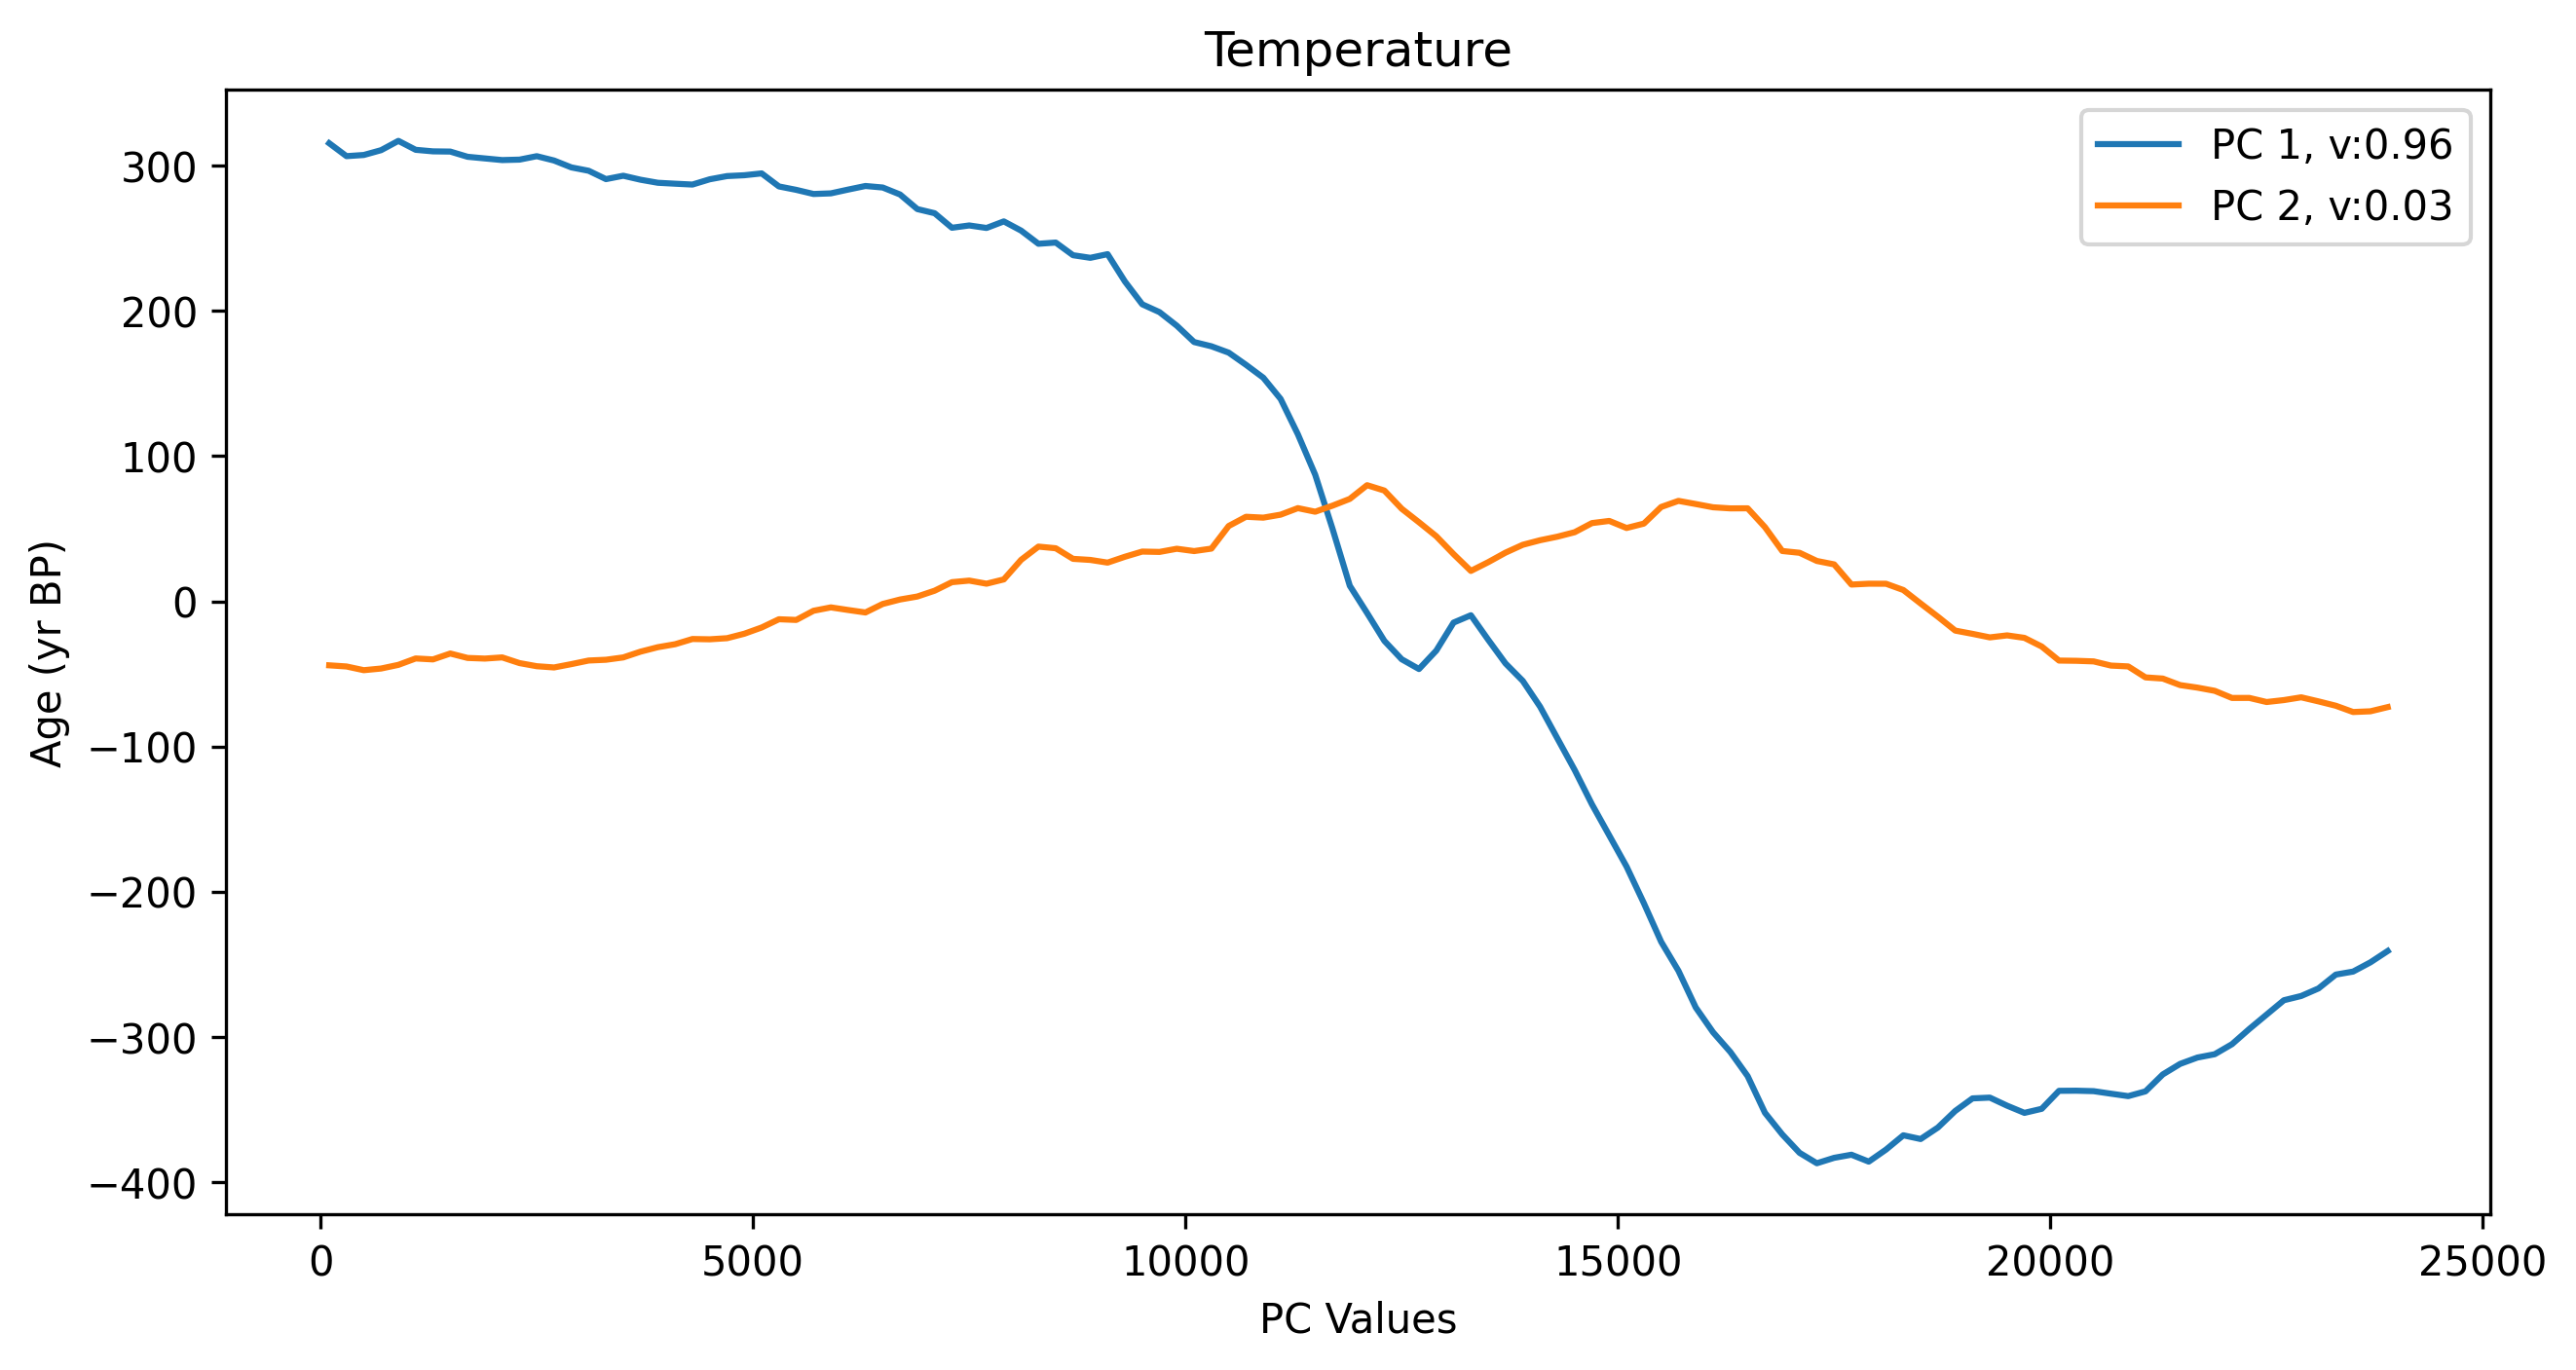

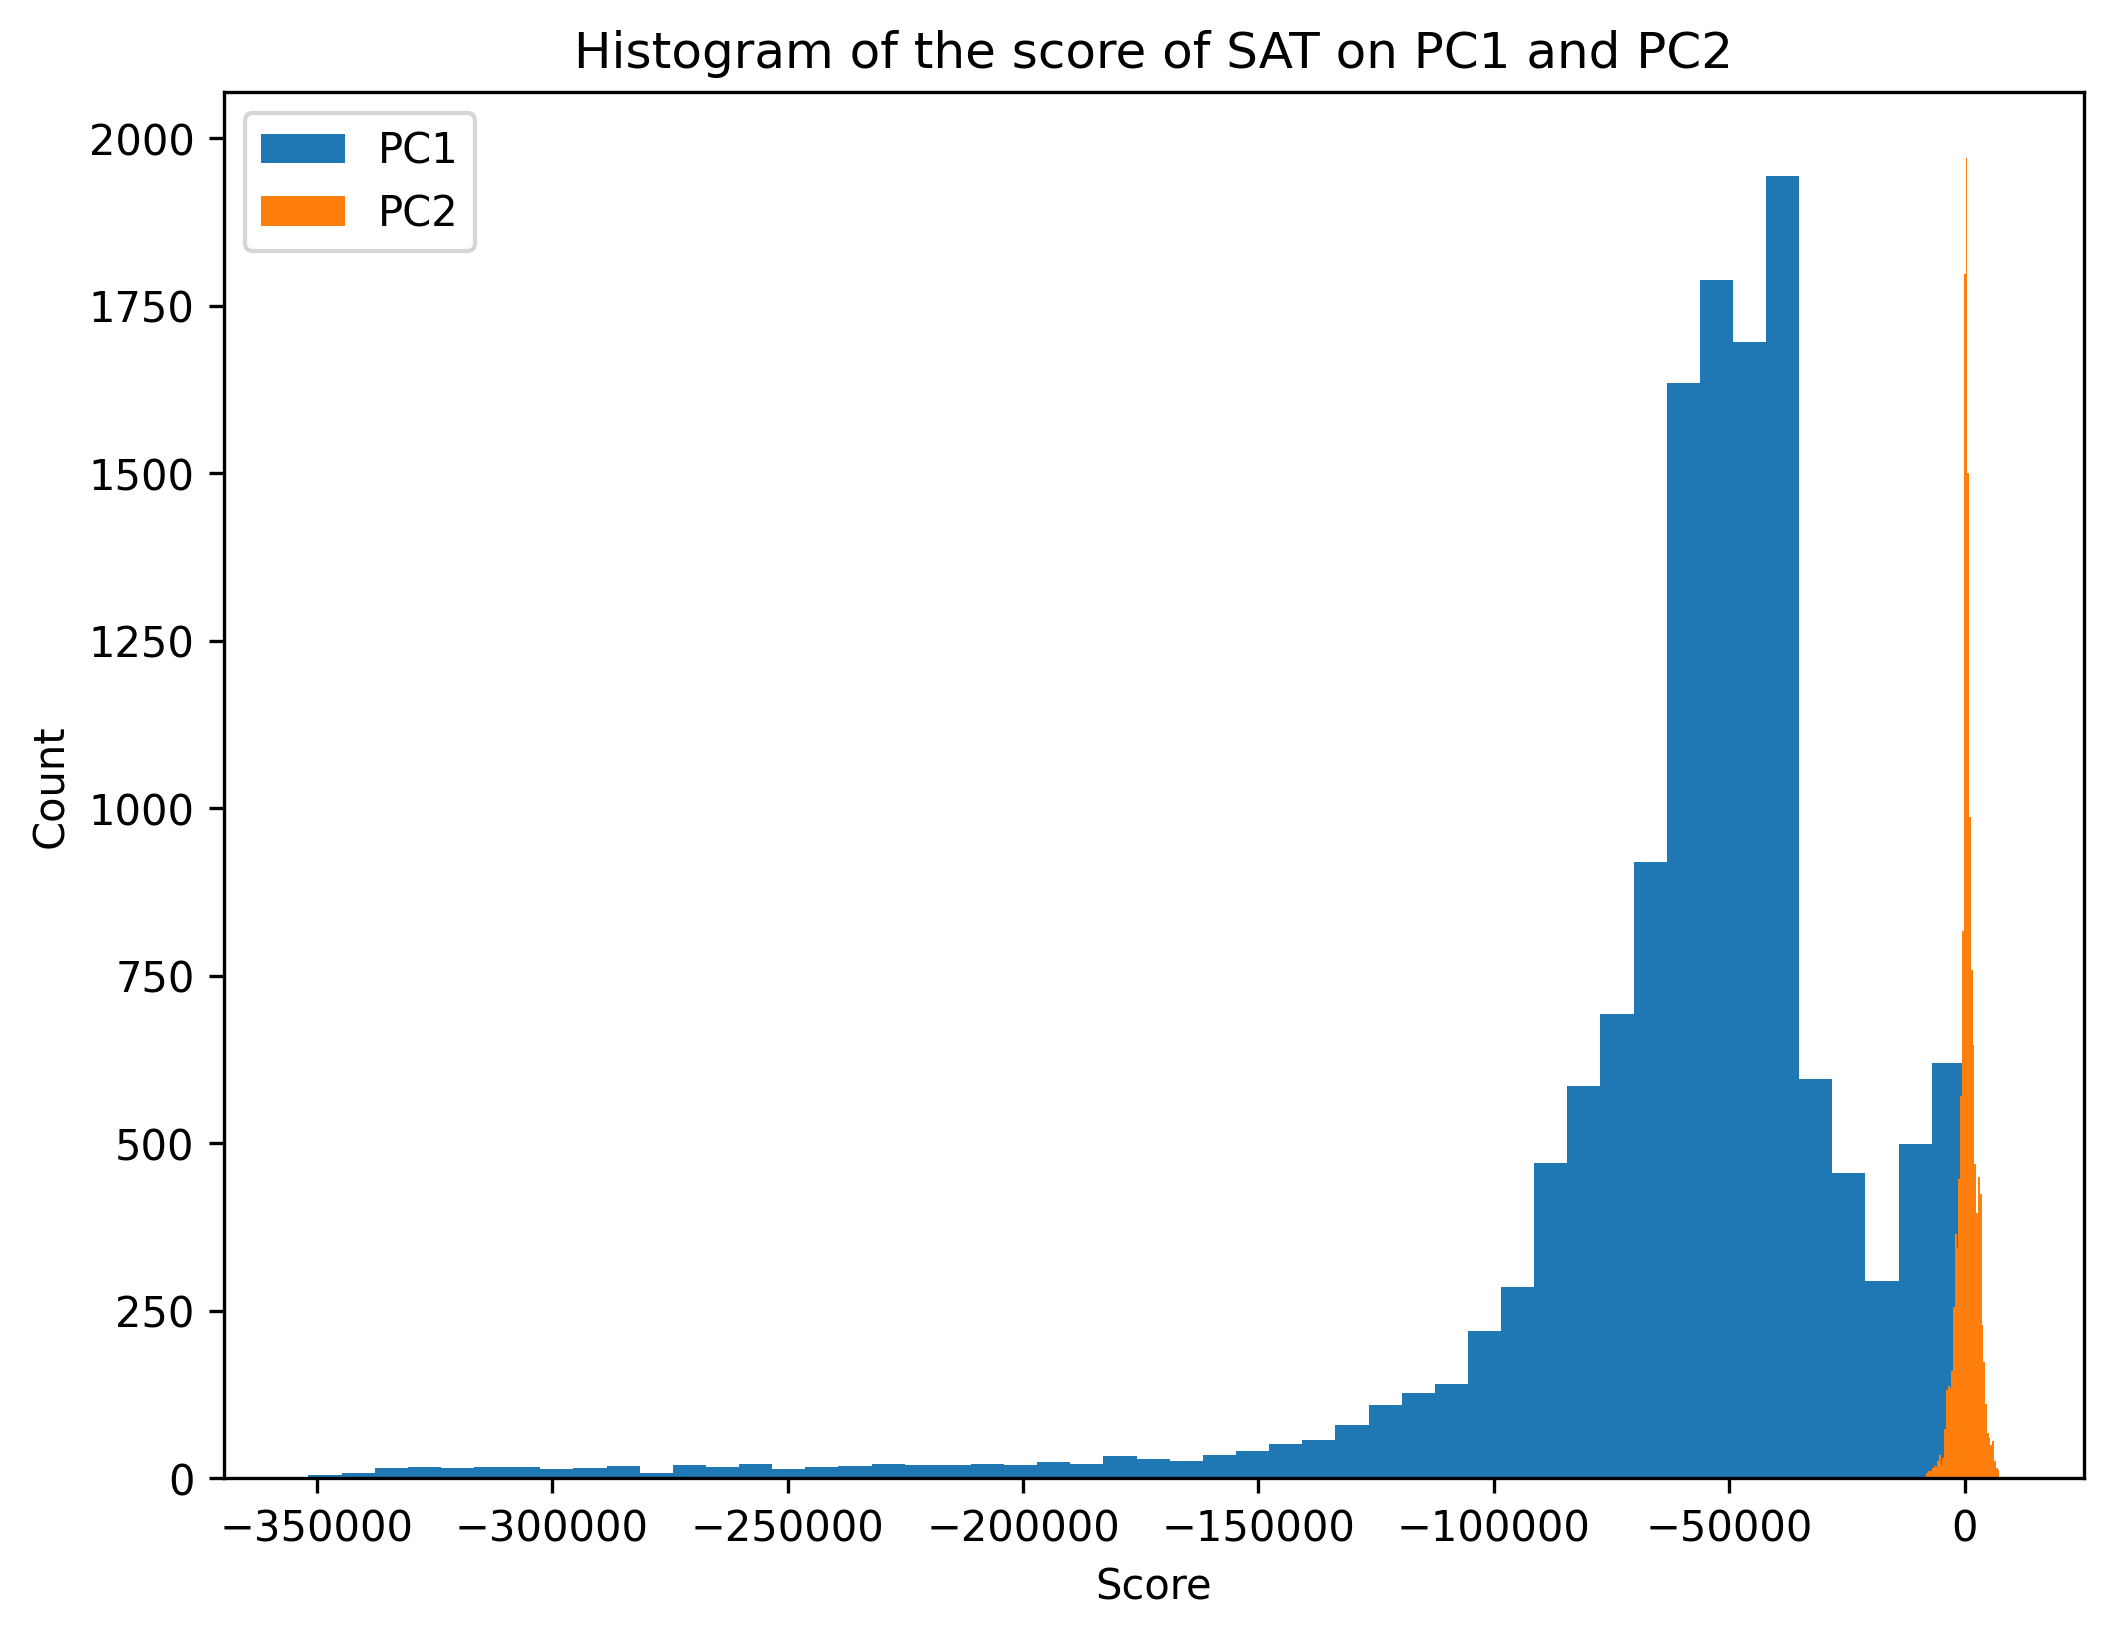

In [25]:
tem_score_centered_weighted_no_zscore=pca_score(sat_centered_weighted, ds_sat, n_pc=2, reversed=False, if_zscore=False)

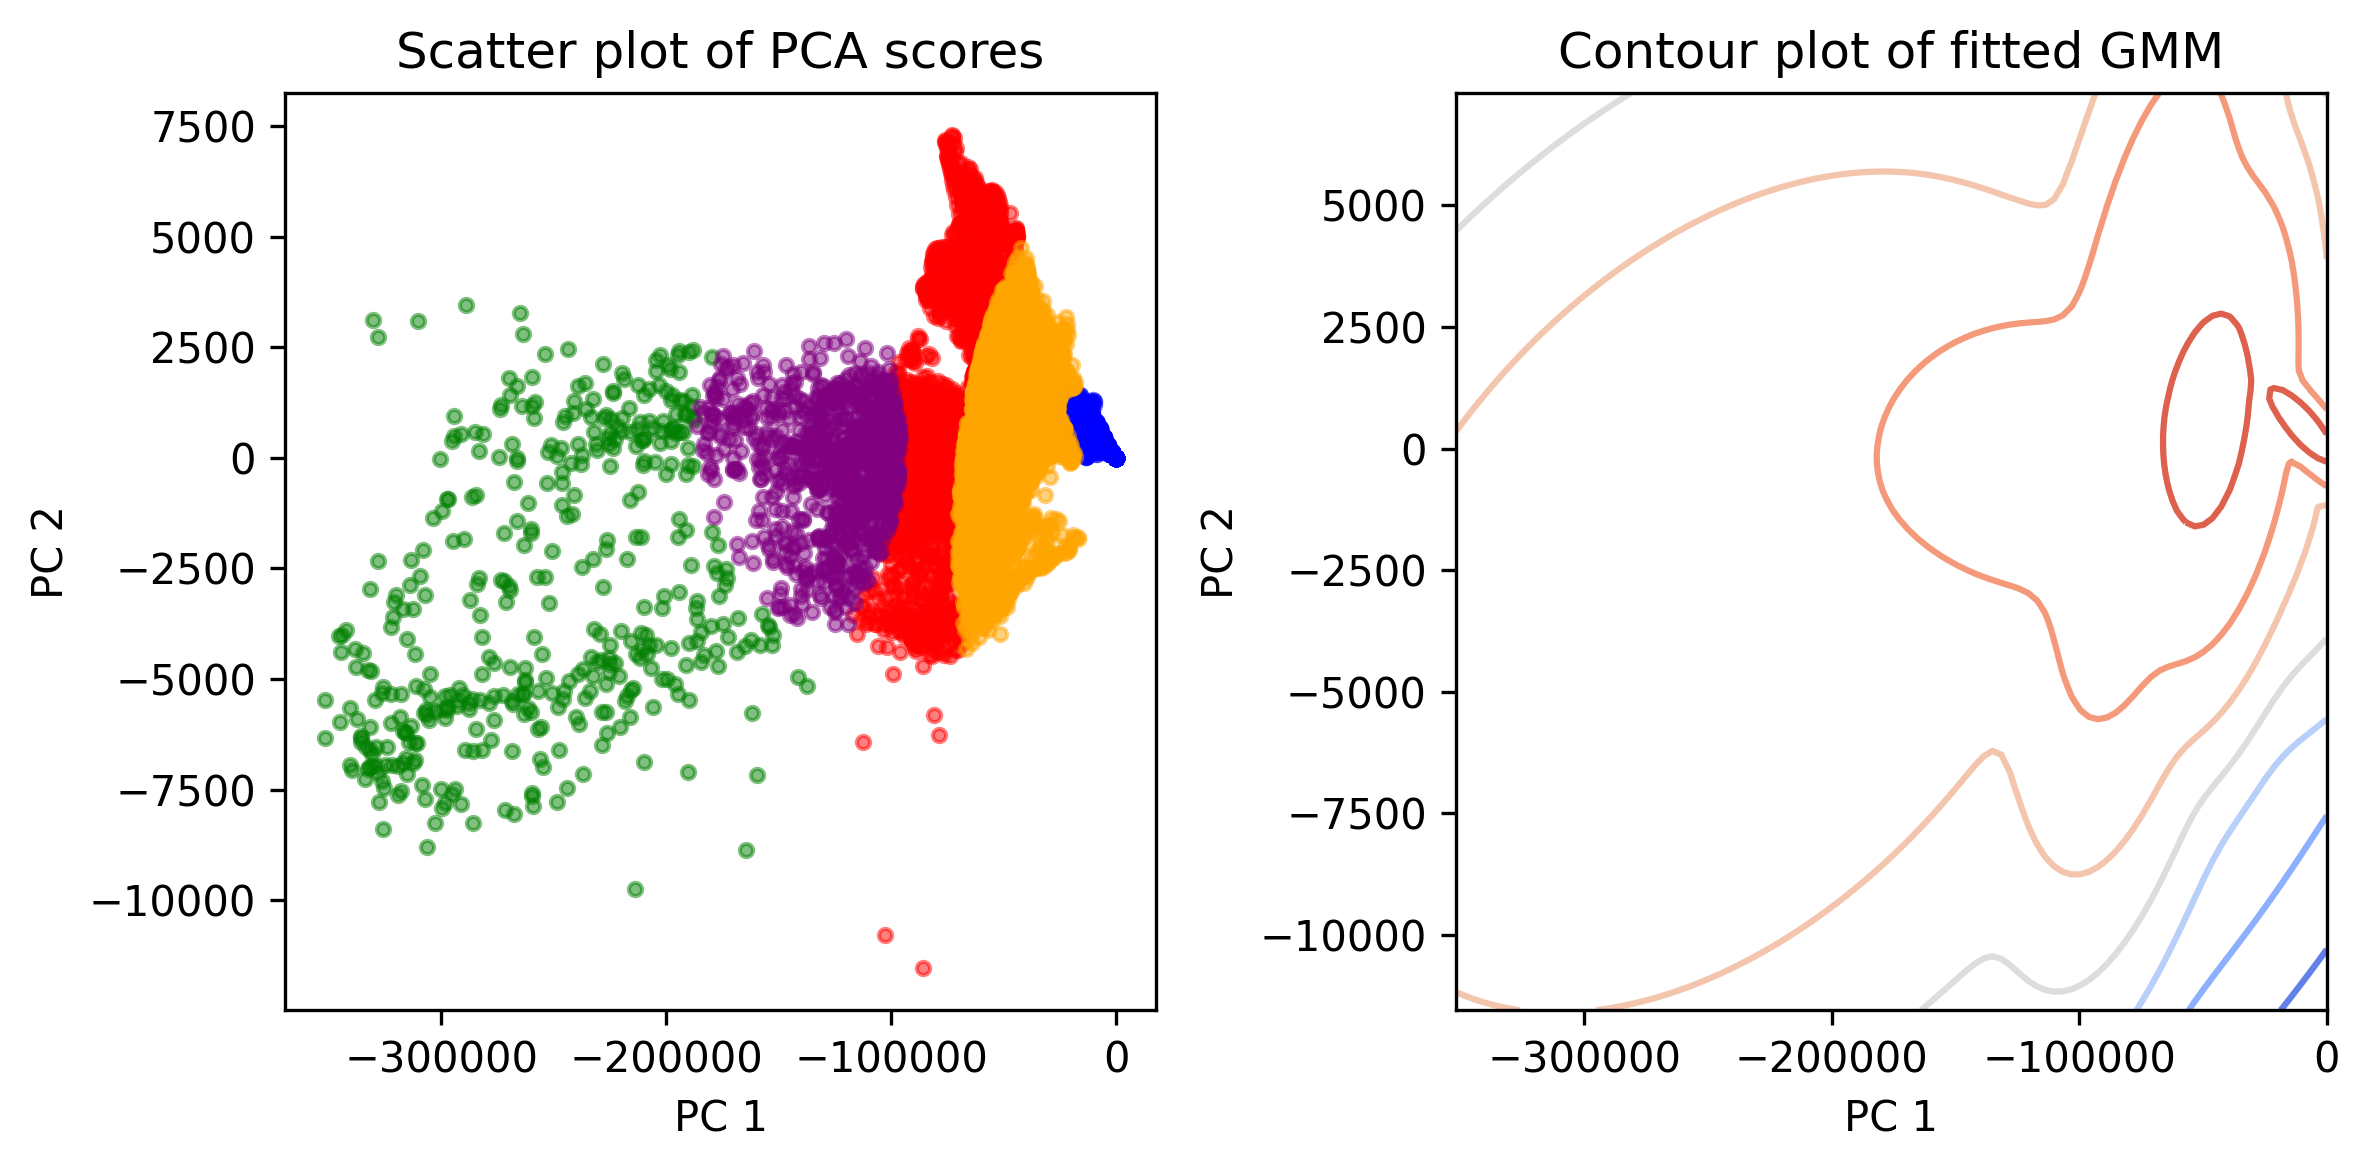

In [30]:
GMM_test(tem_score_centered_weighted_no_zscore, ds_sat, n_components=5)

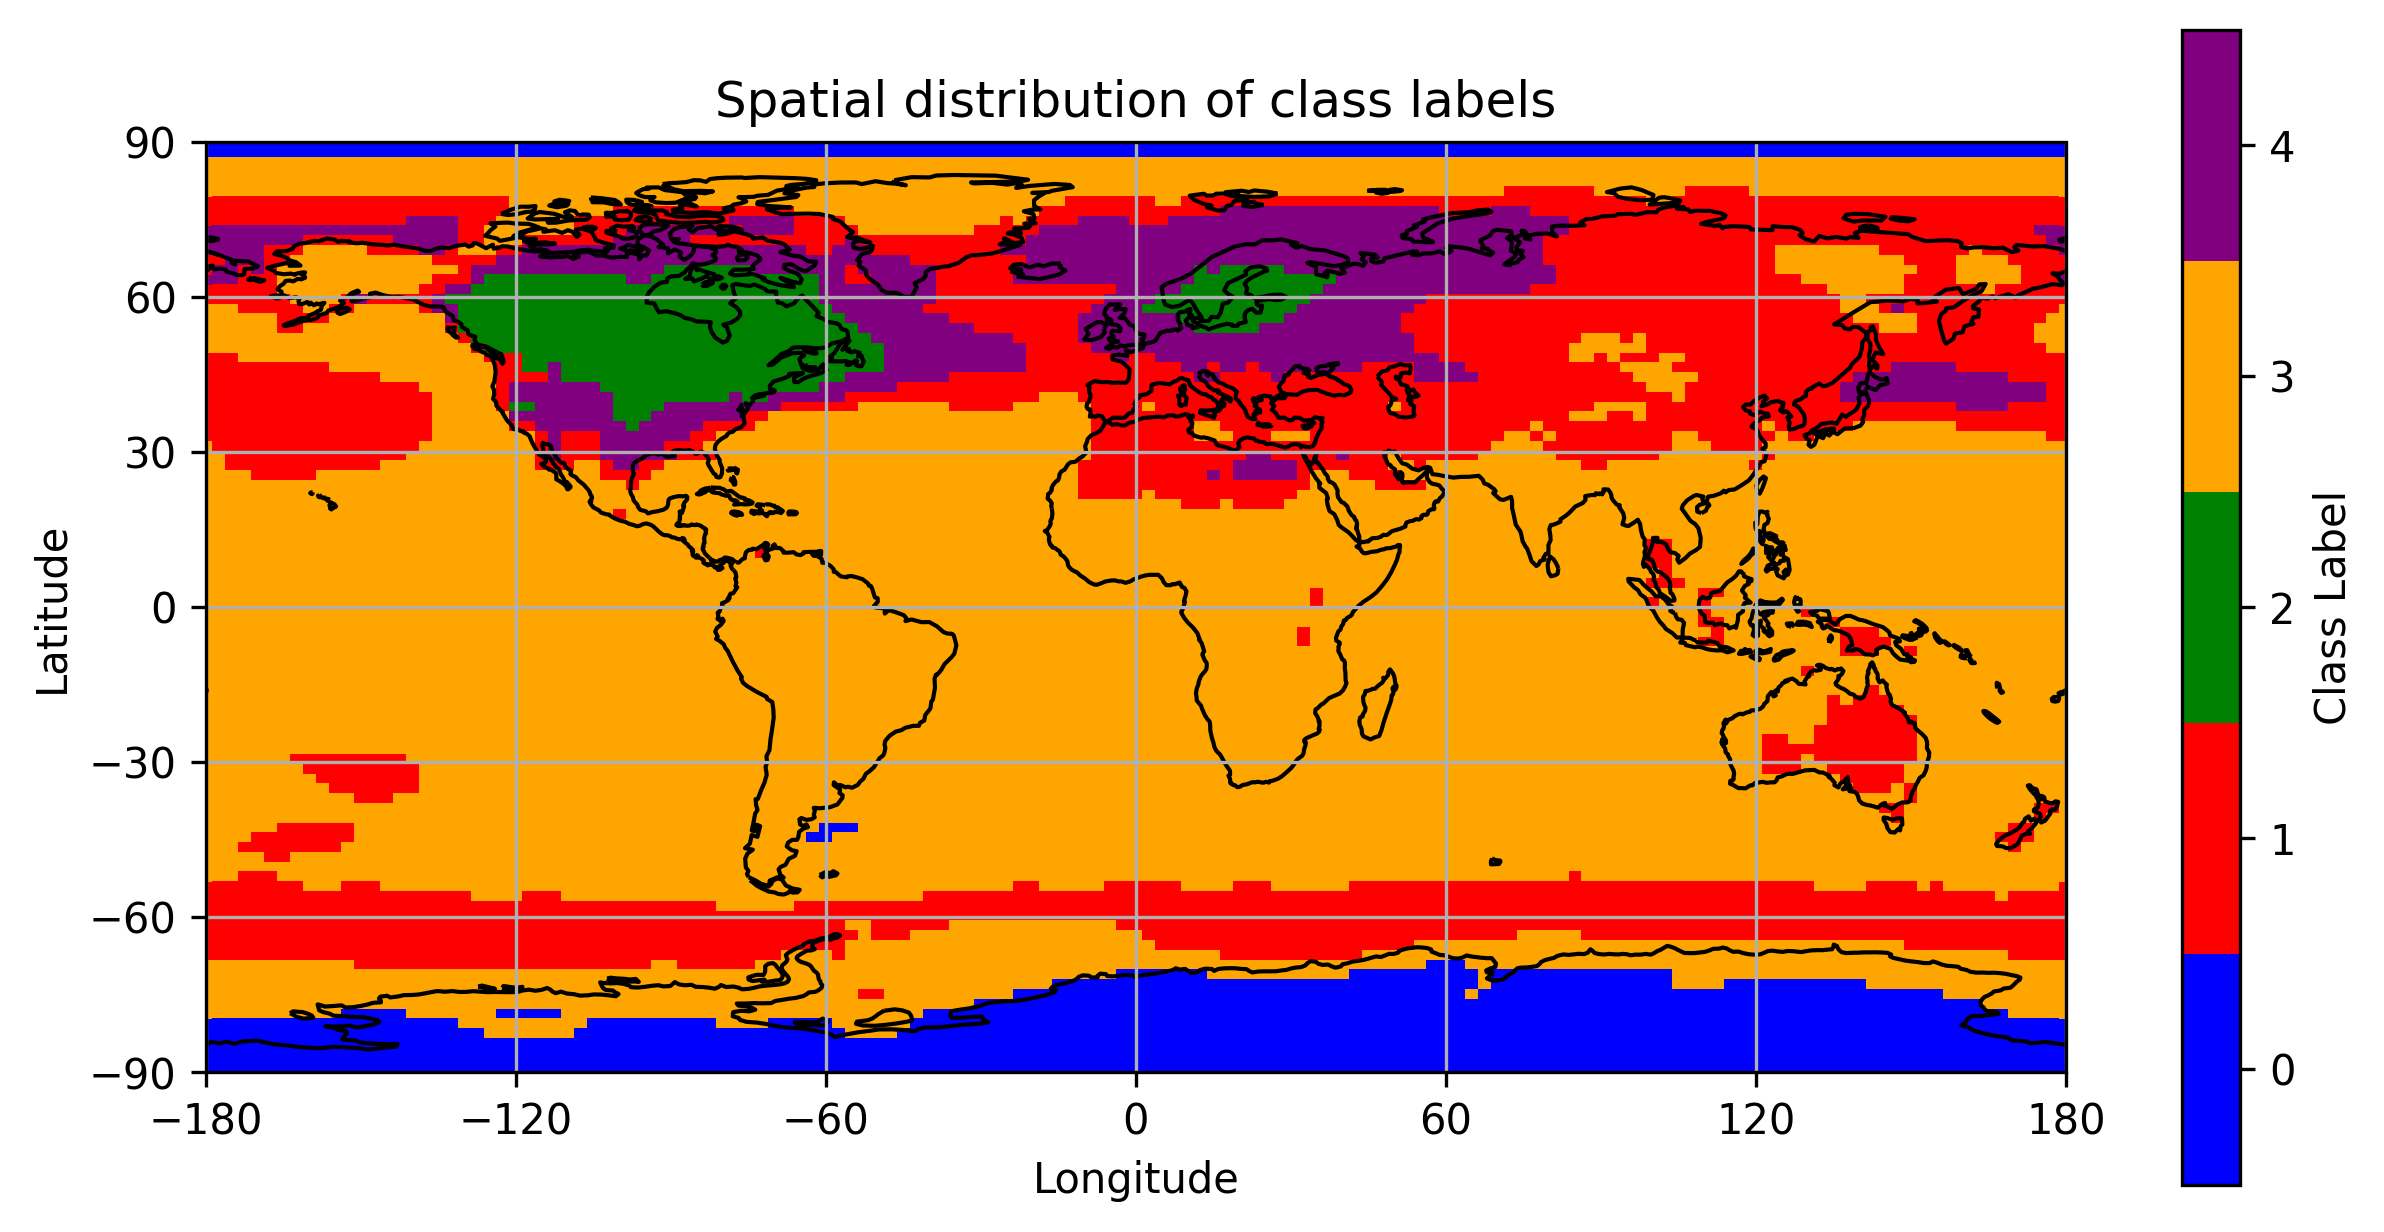

In [31]:
import GMM_functions as gf
gf.plot_labels(ds_sat)

variation explained by PC1 and PC2 for temperature: [0.96177655 0.02574335]


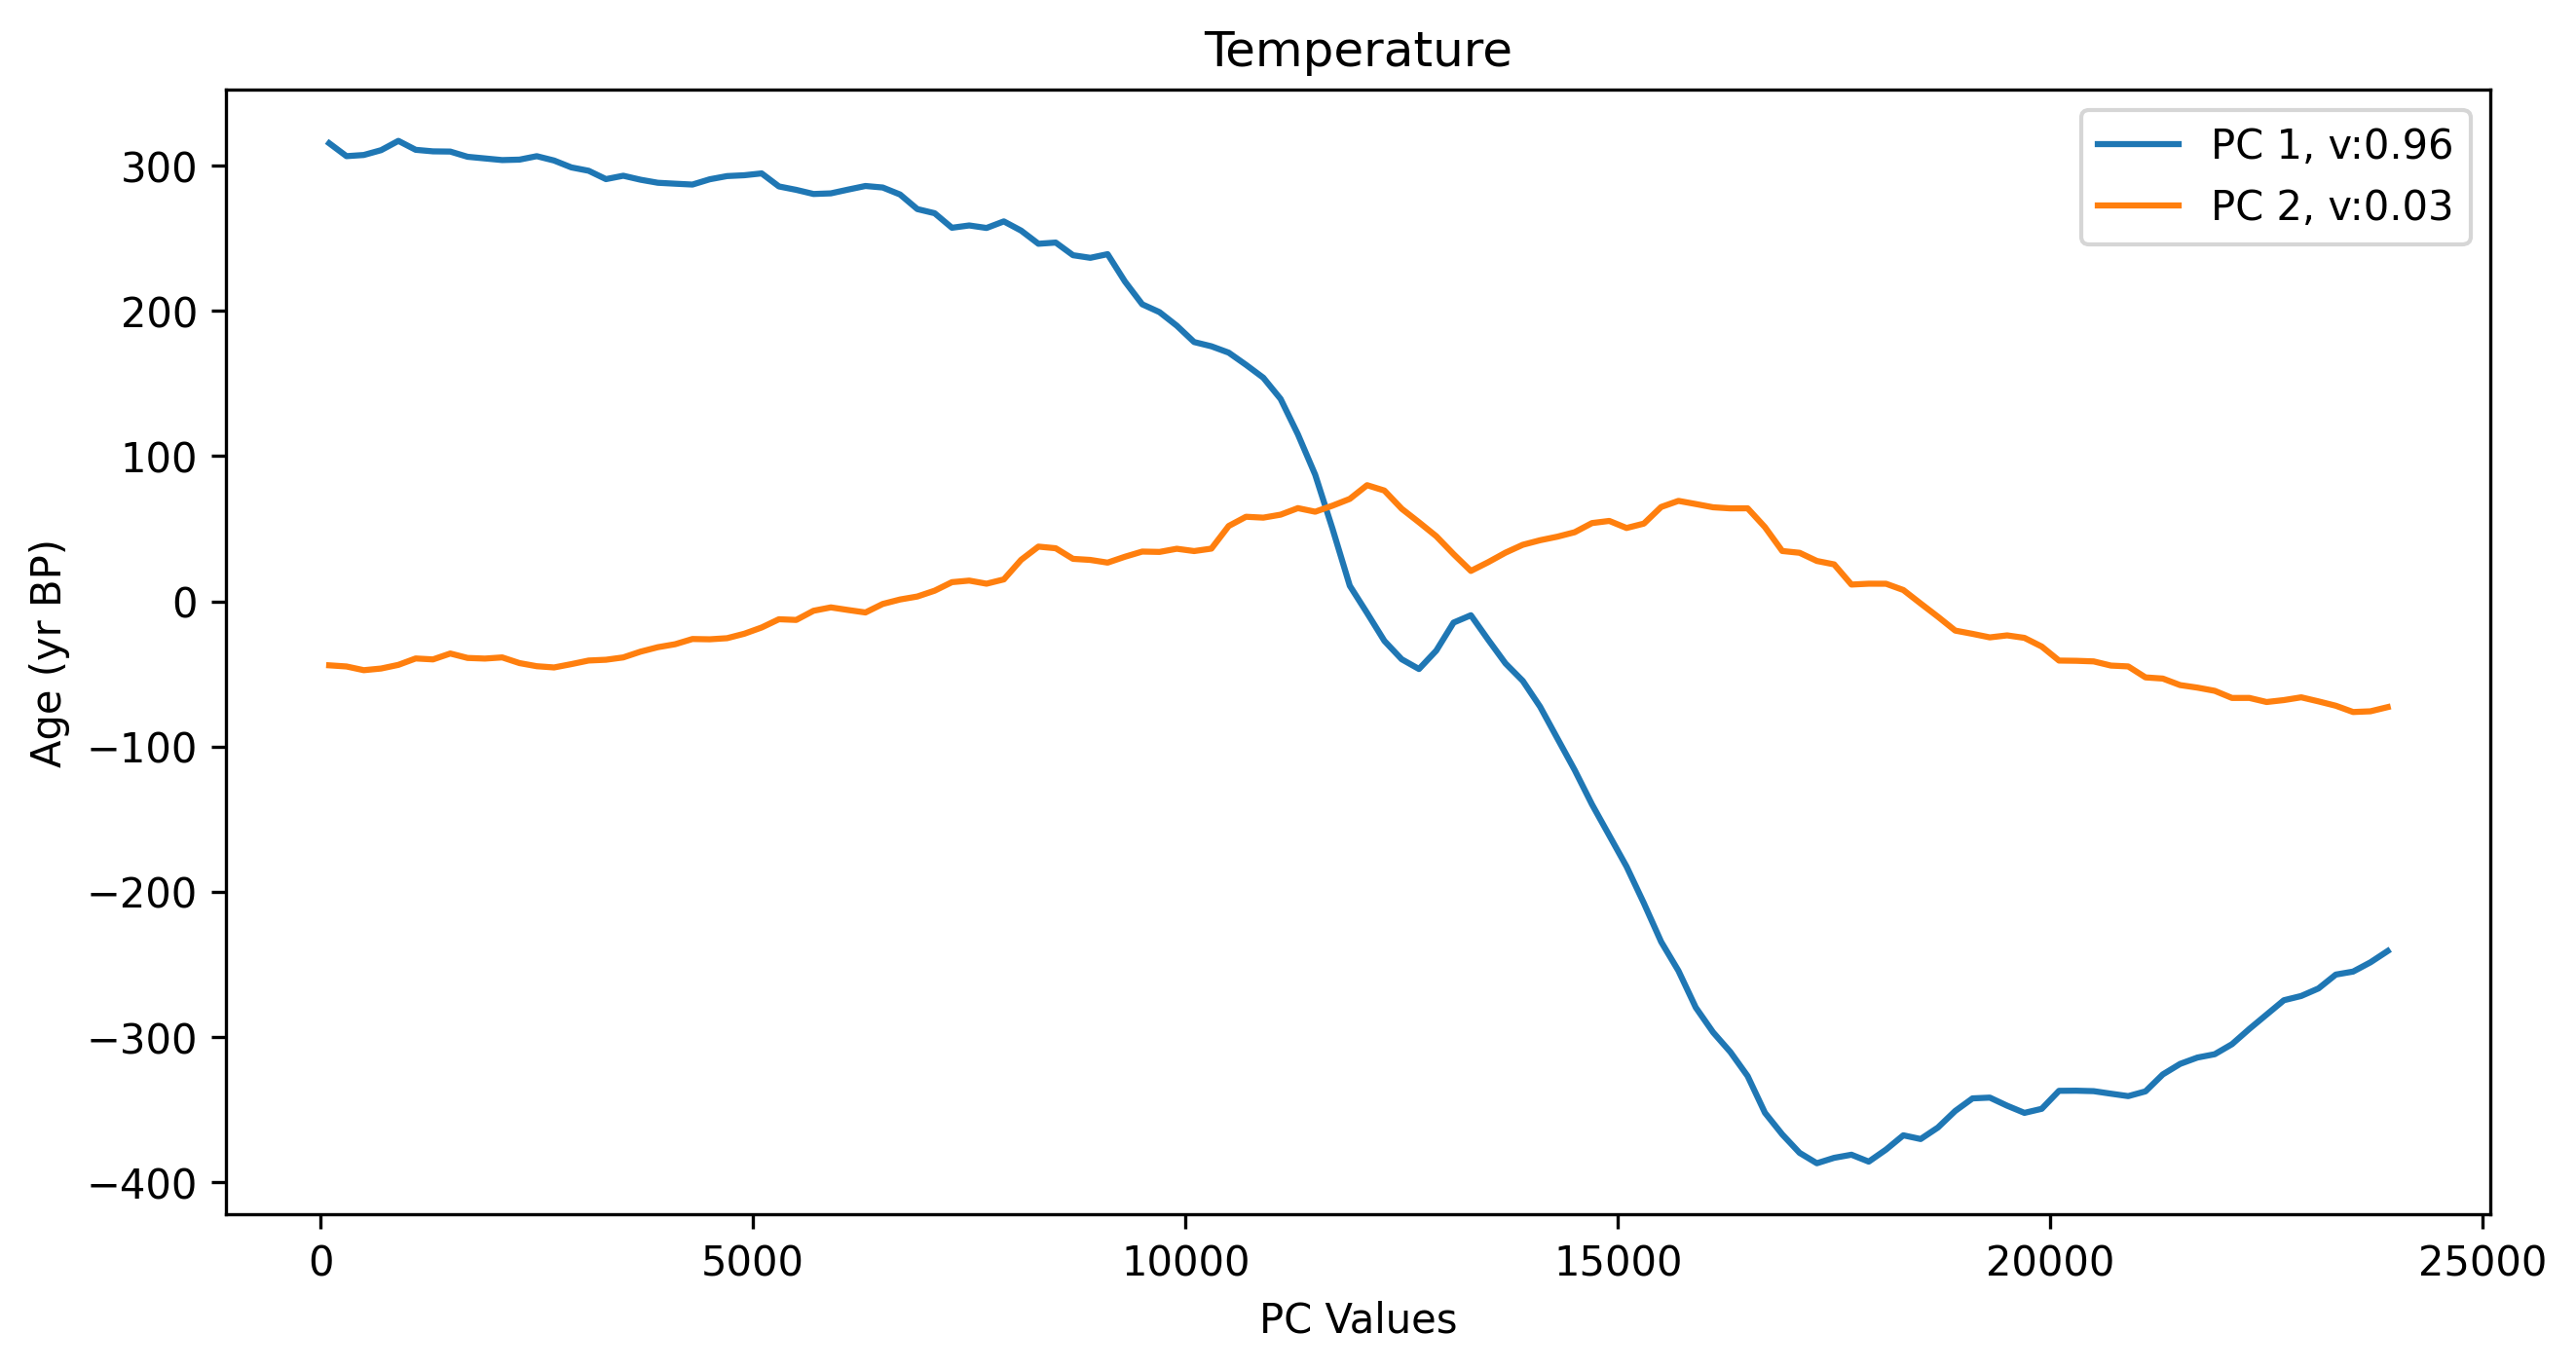

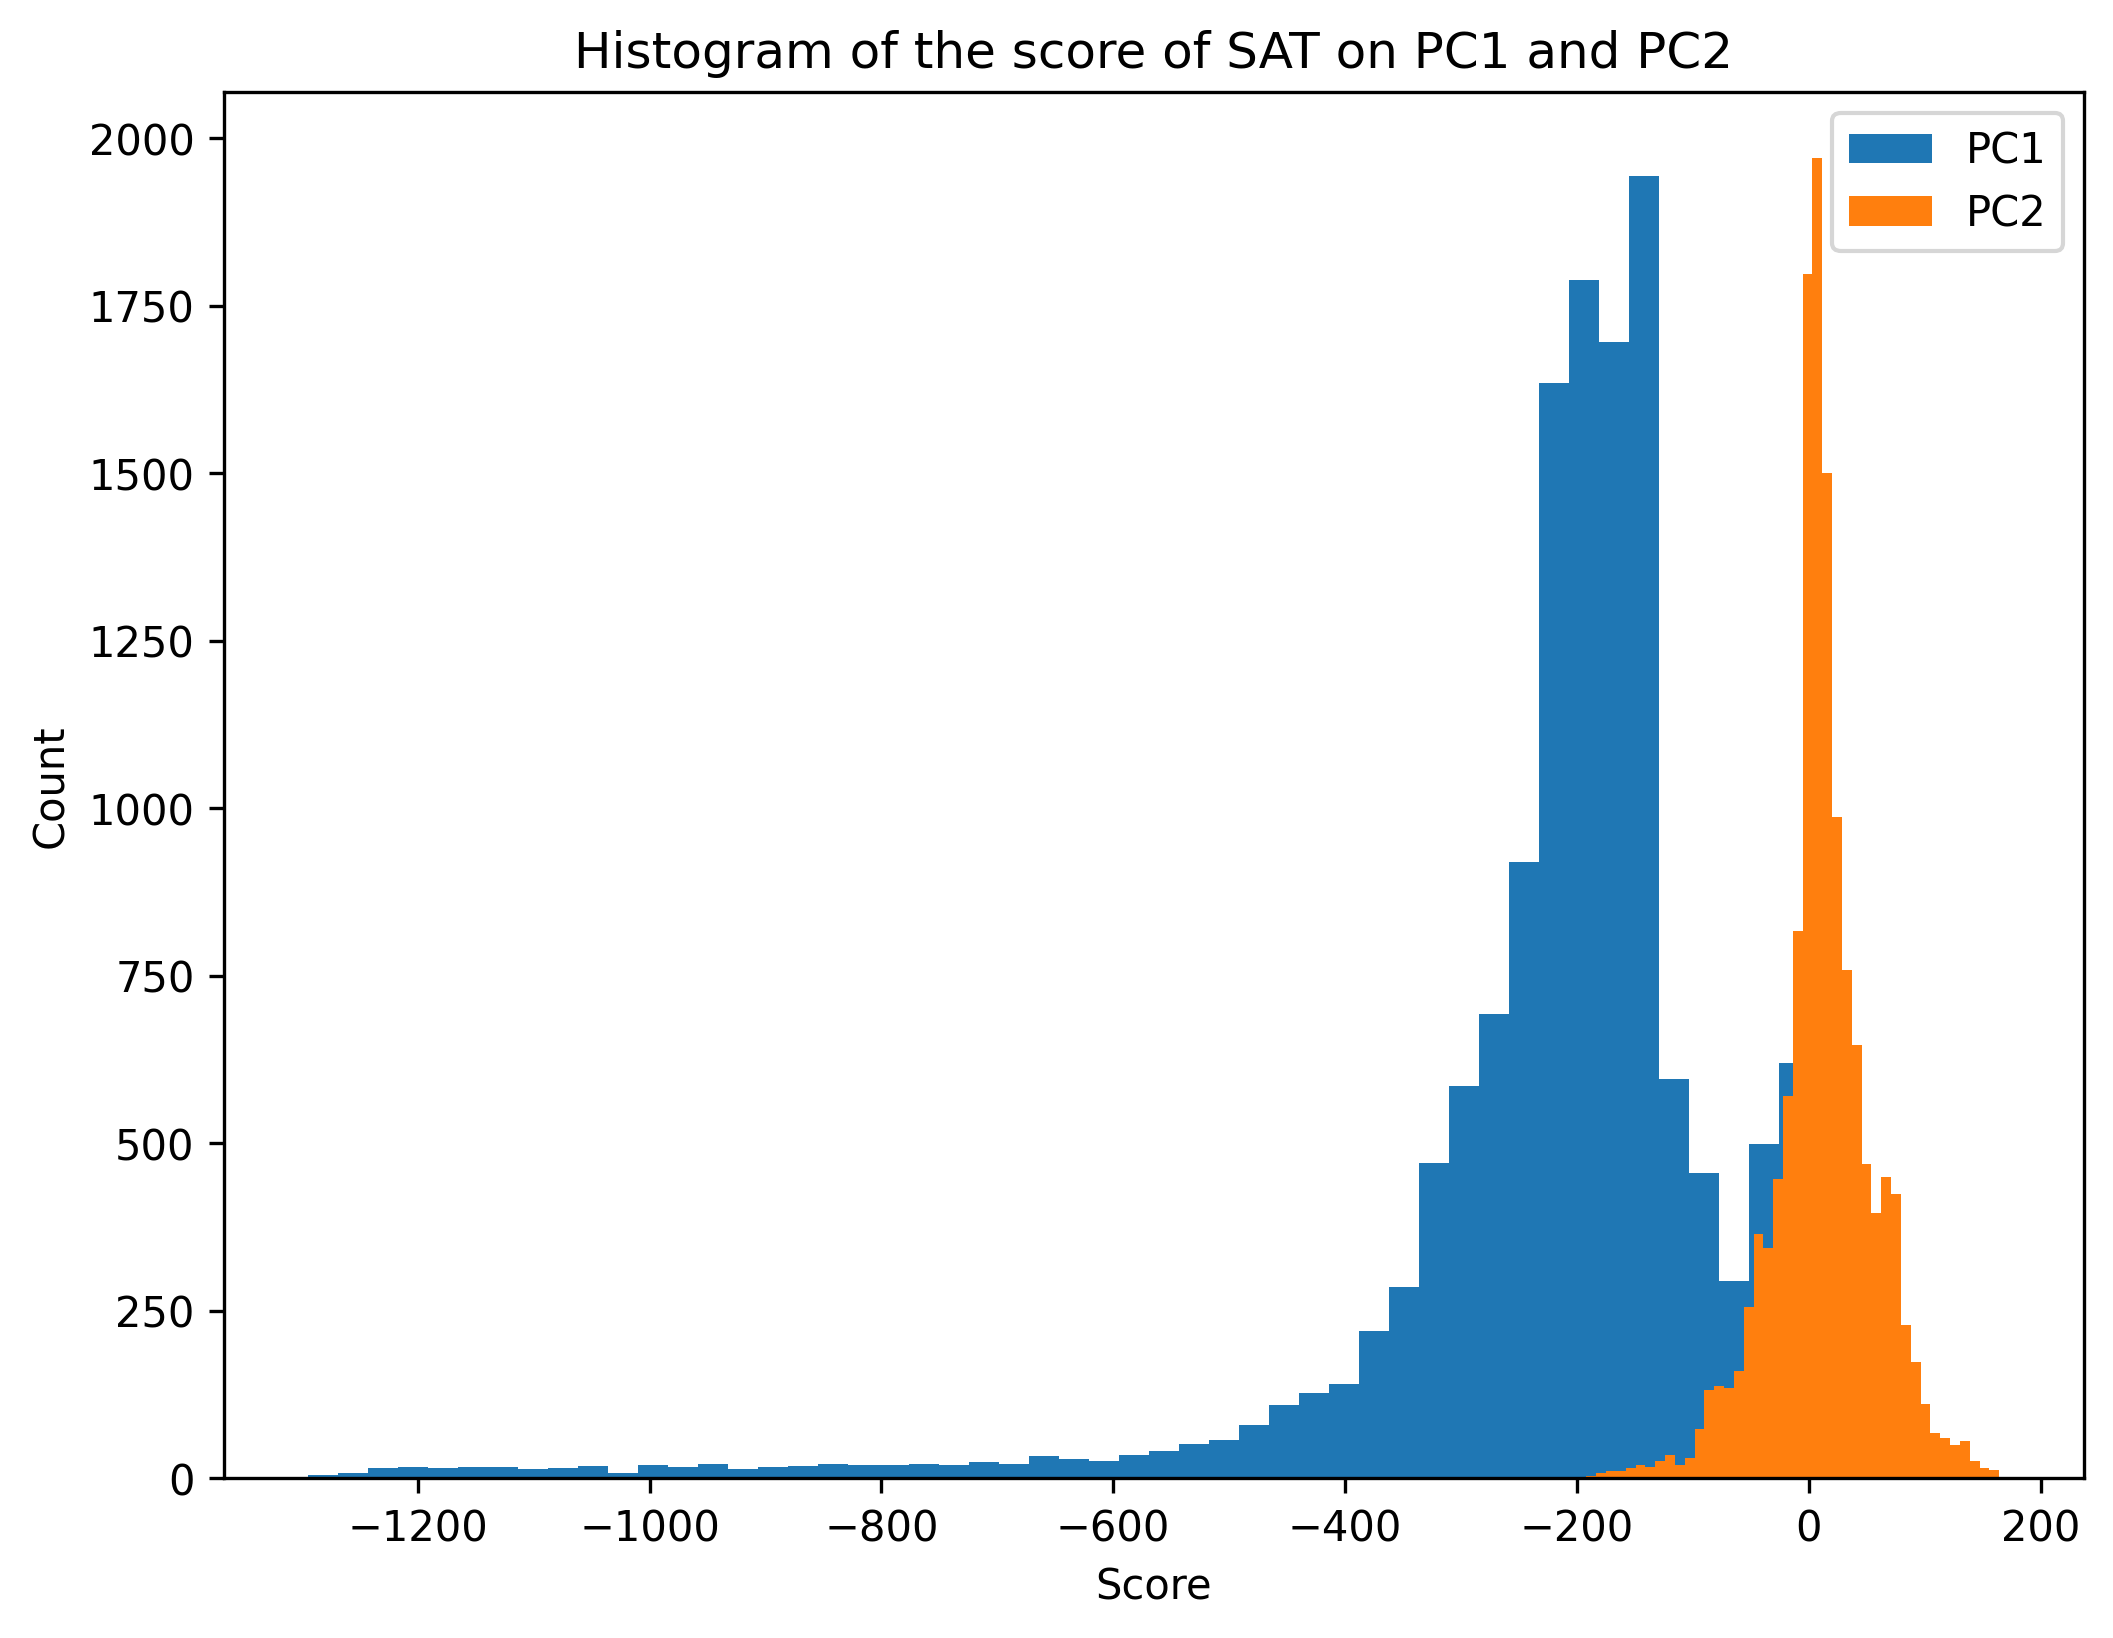

In [32]:
tem_score_centered_weighted_zscore=pca_score(sat_centered_weighted, ds_sat, n_pc=2, reversed=False, if_zscore=True)

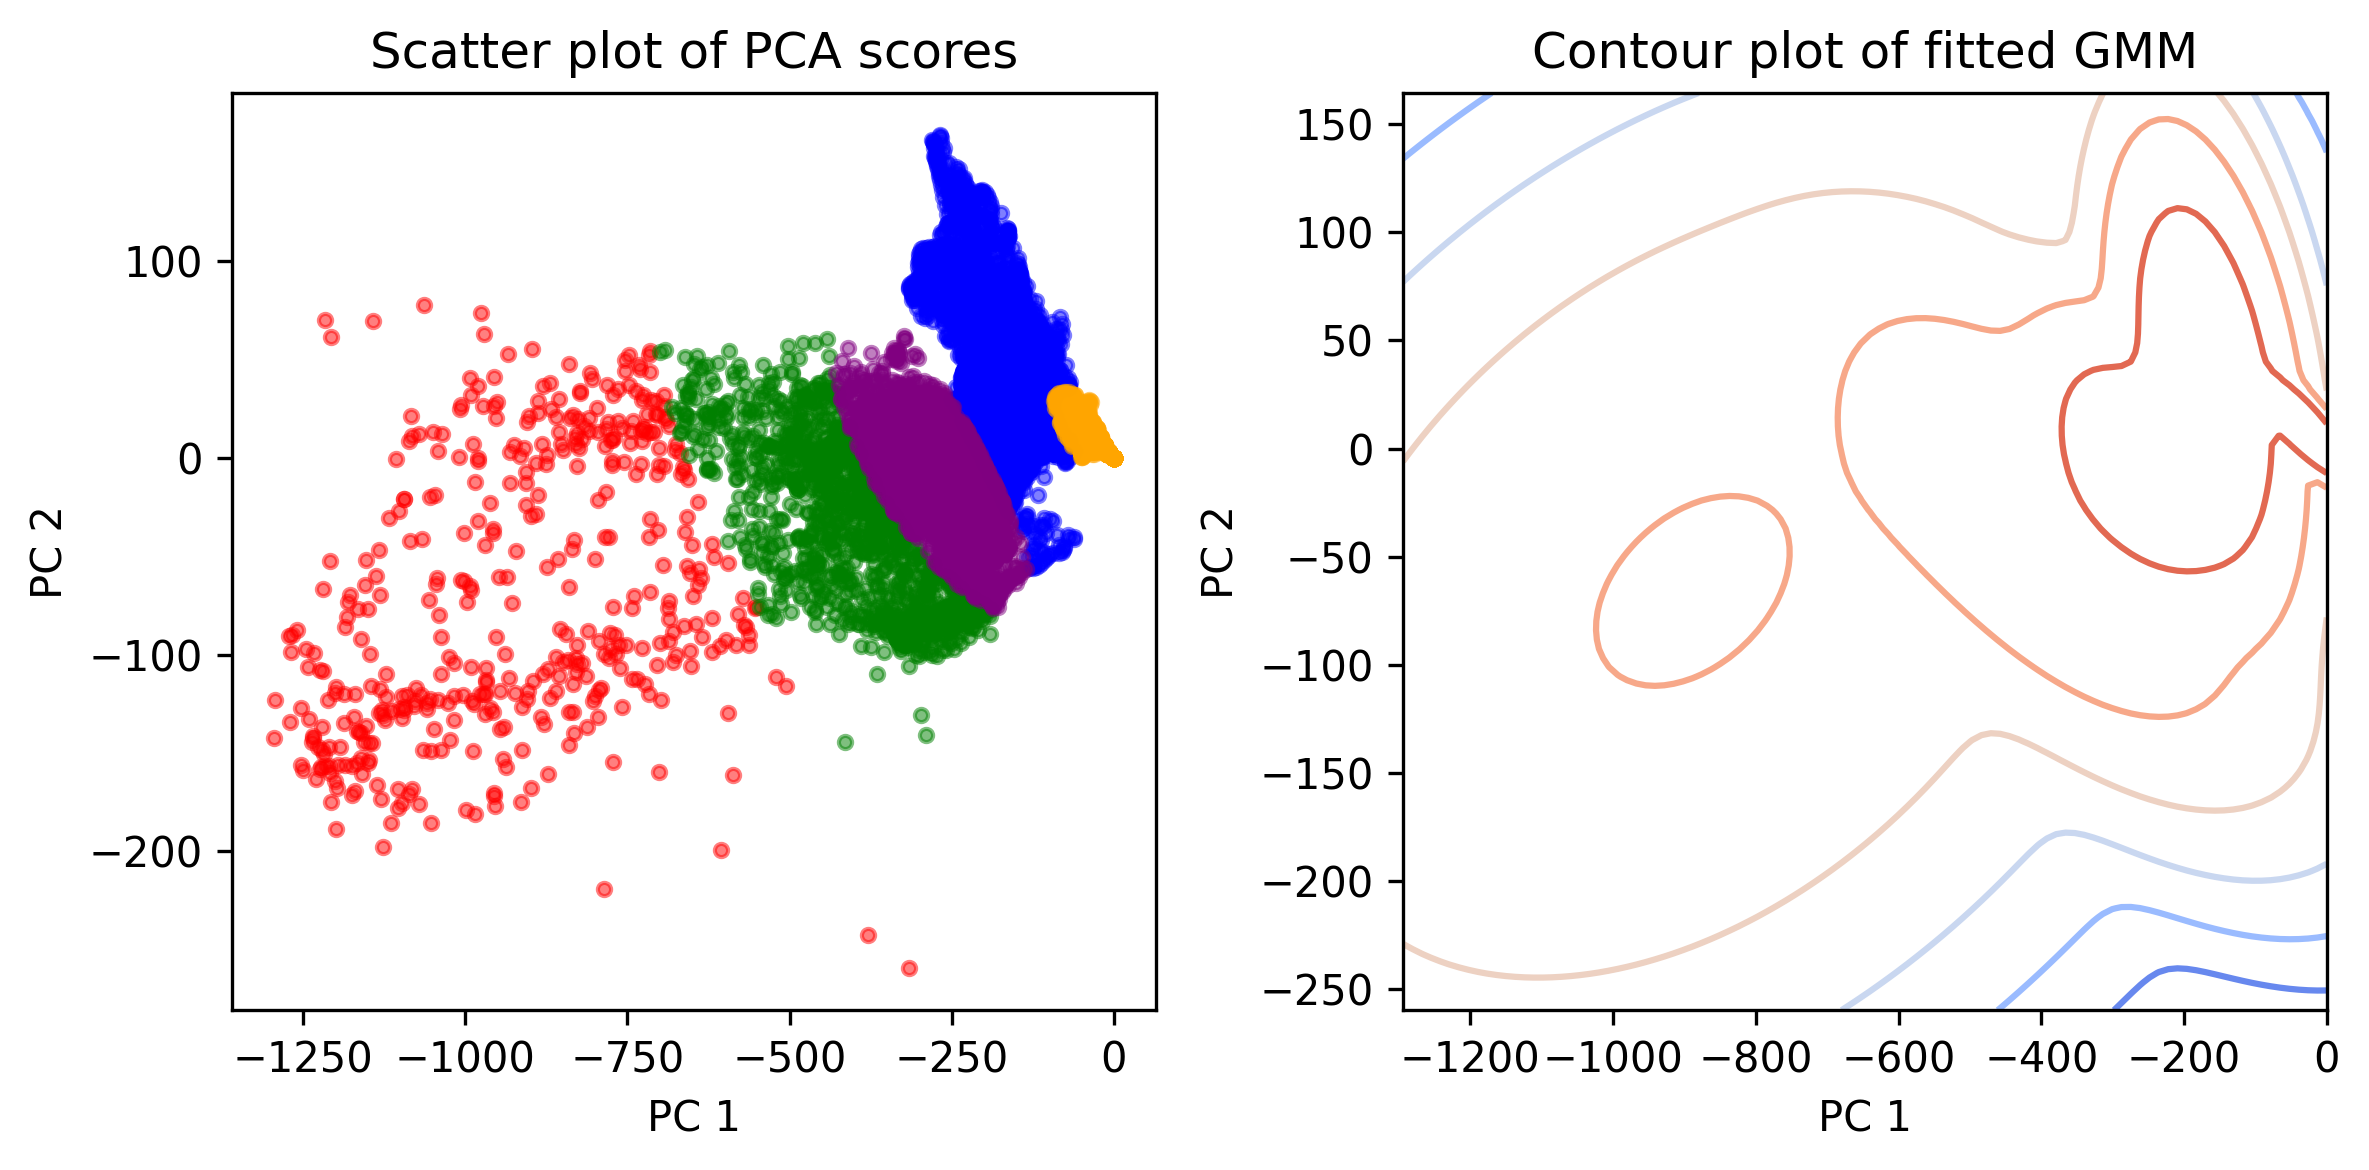

In [33]:
GMM_test(tem_score_centered_weighted_zscore, ds_sat, n_components=5)

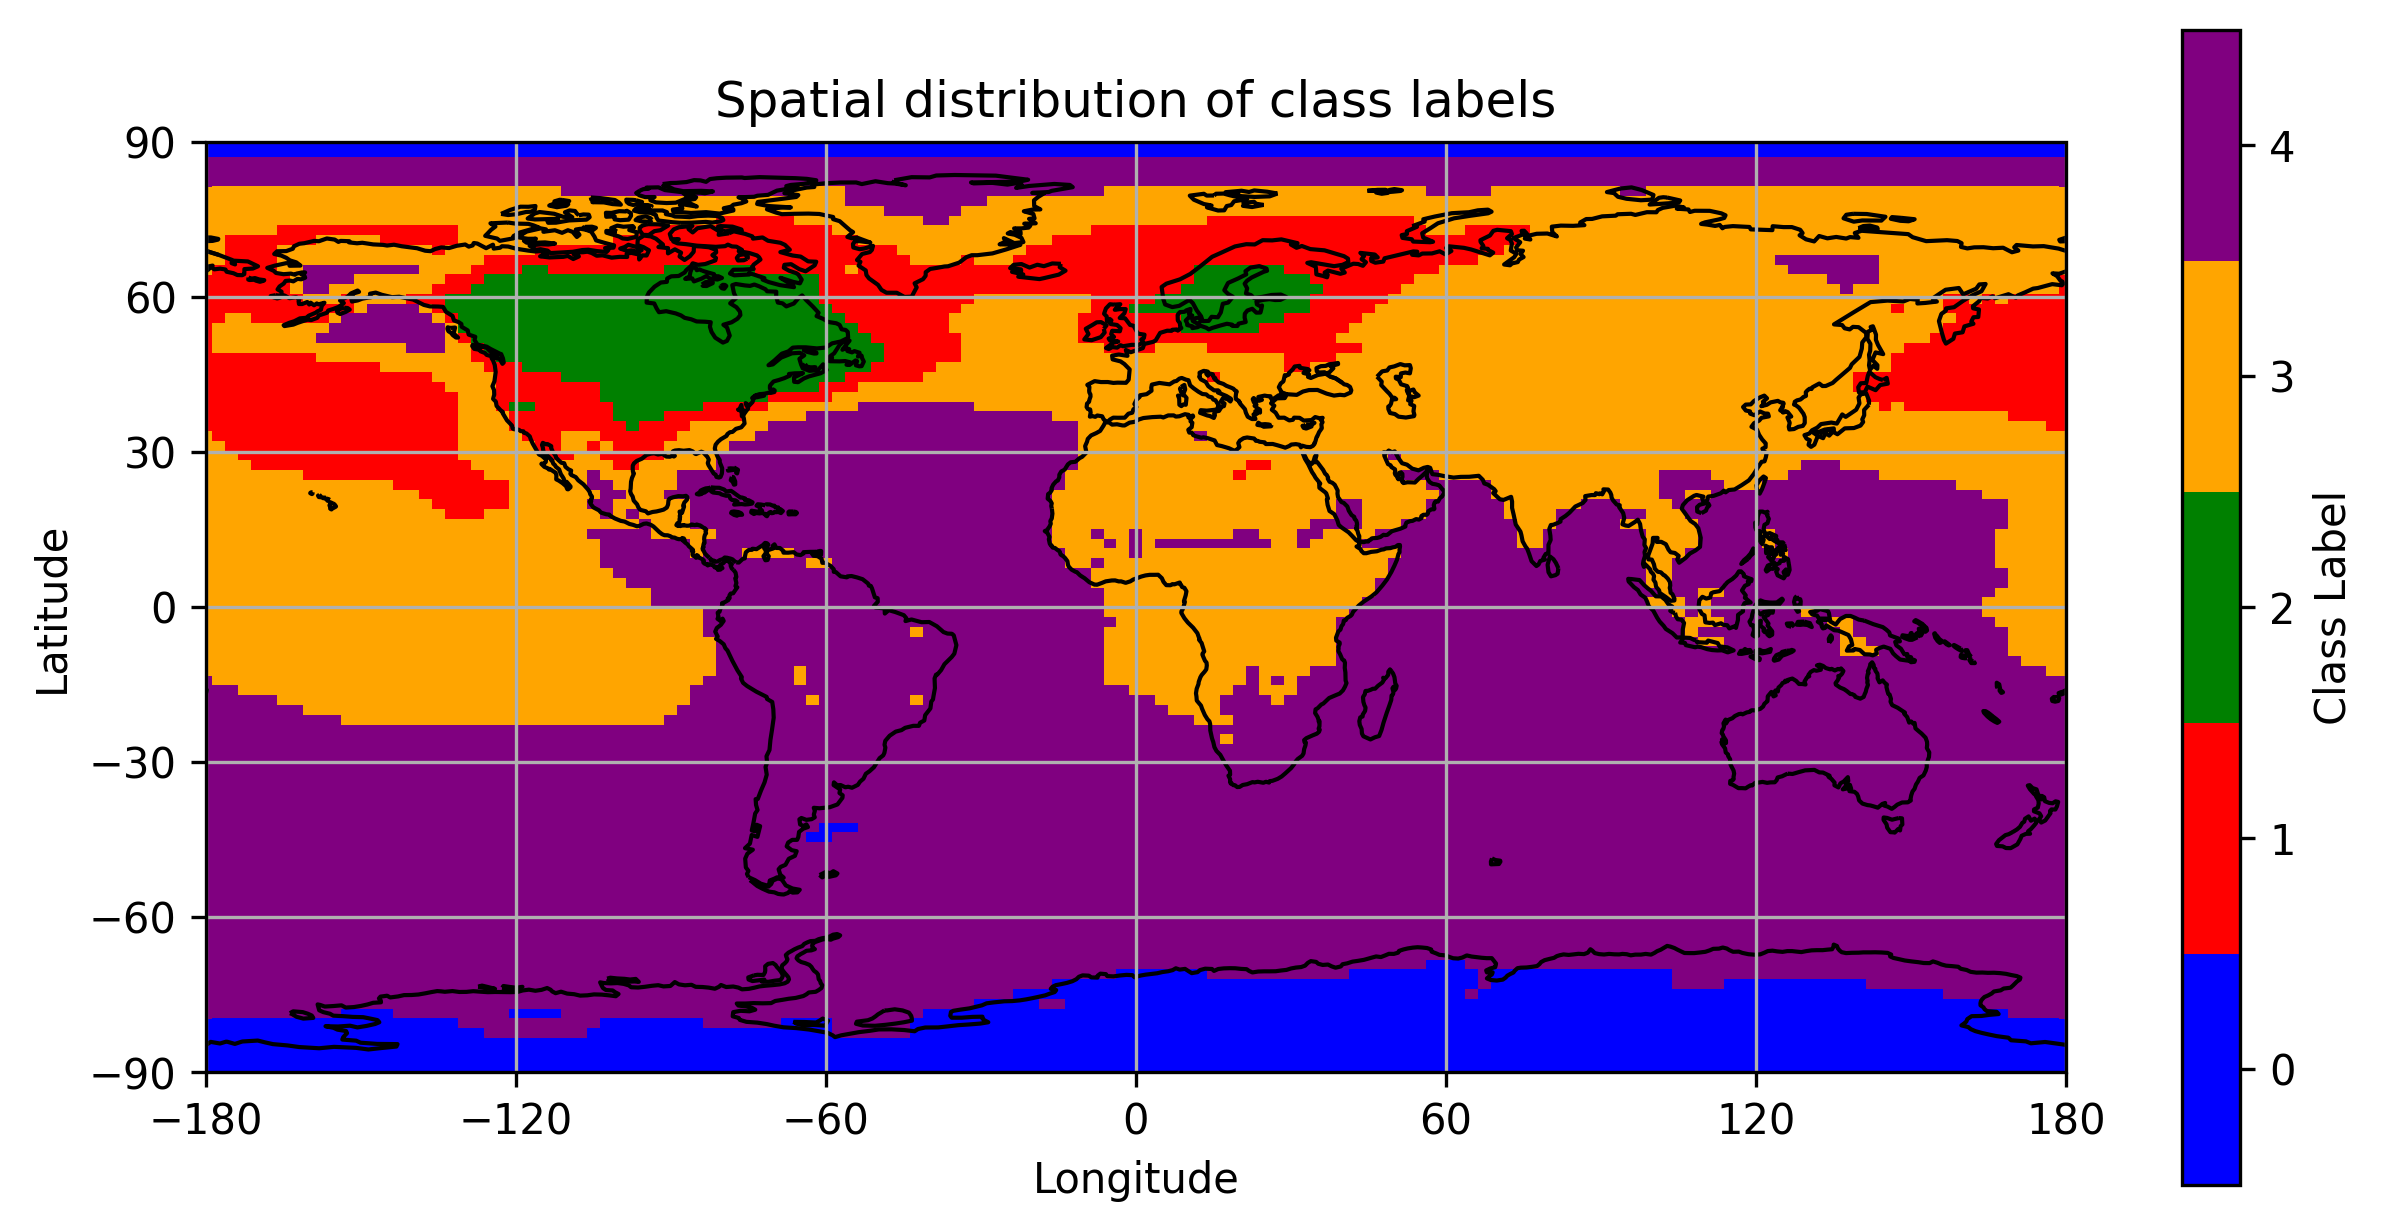

In [24]:
import GMM_functions as gf
gf.plot_labels(ds_sat)

variation explained by PC1 and PC2 for temperature: [0.8886159  0.06761192]


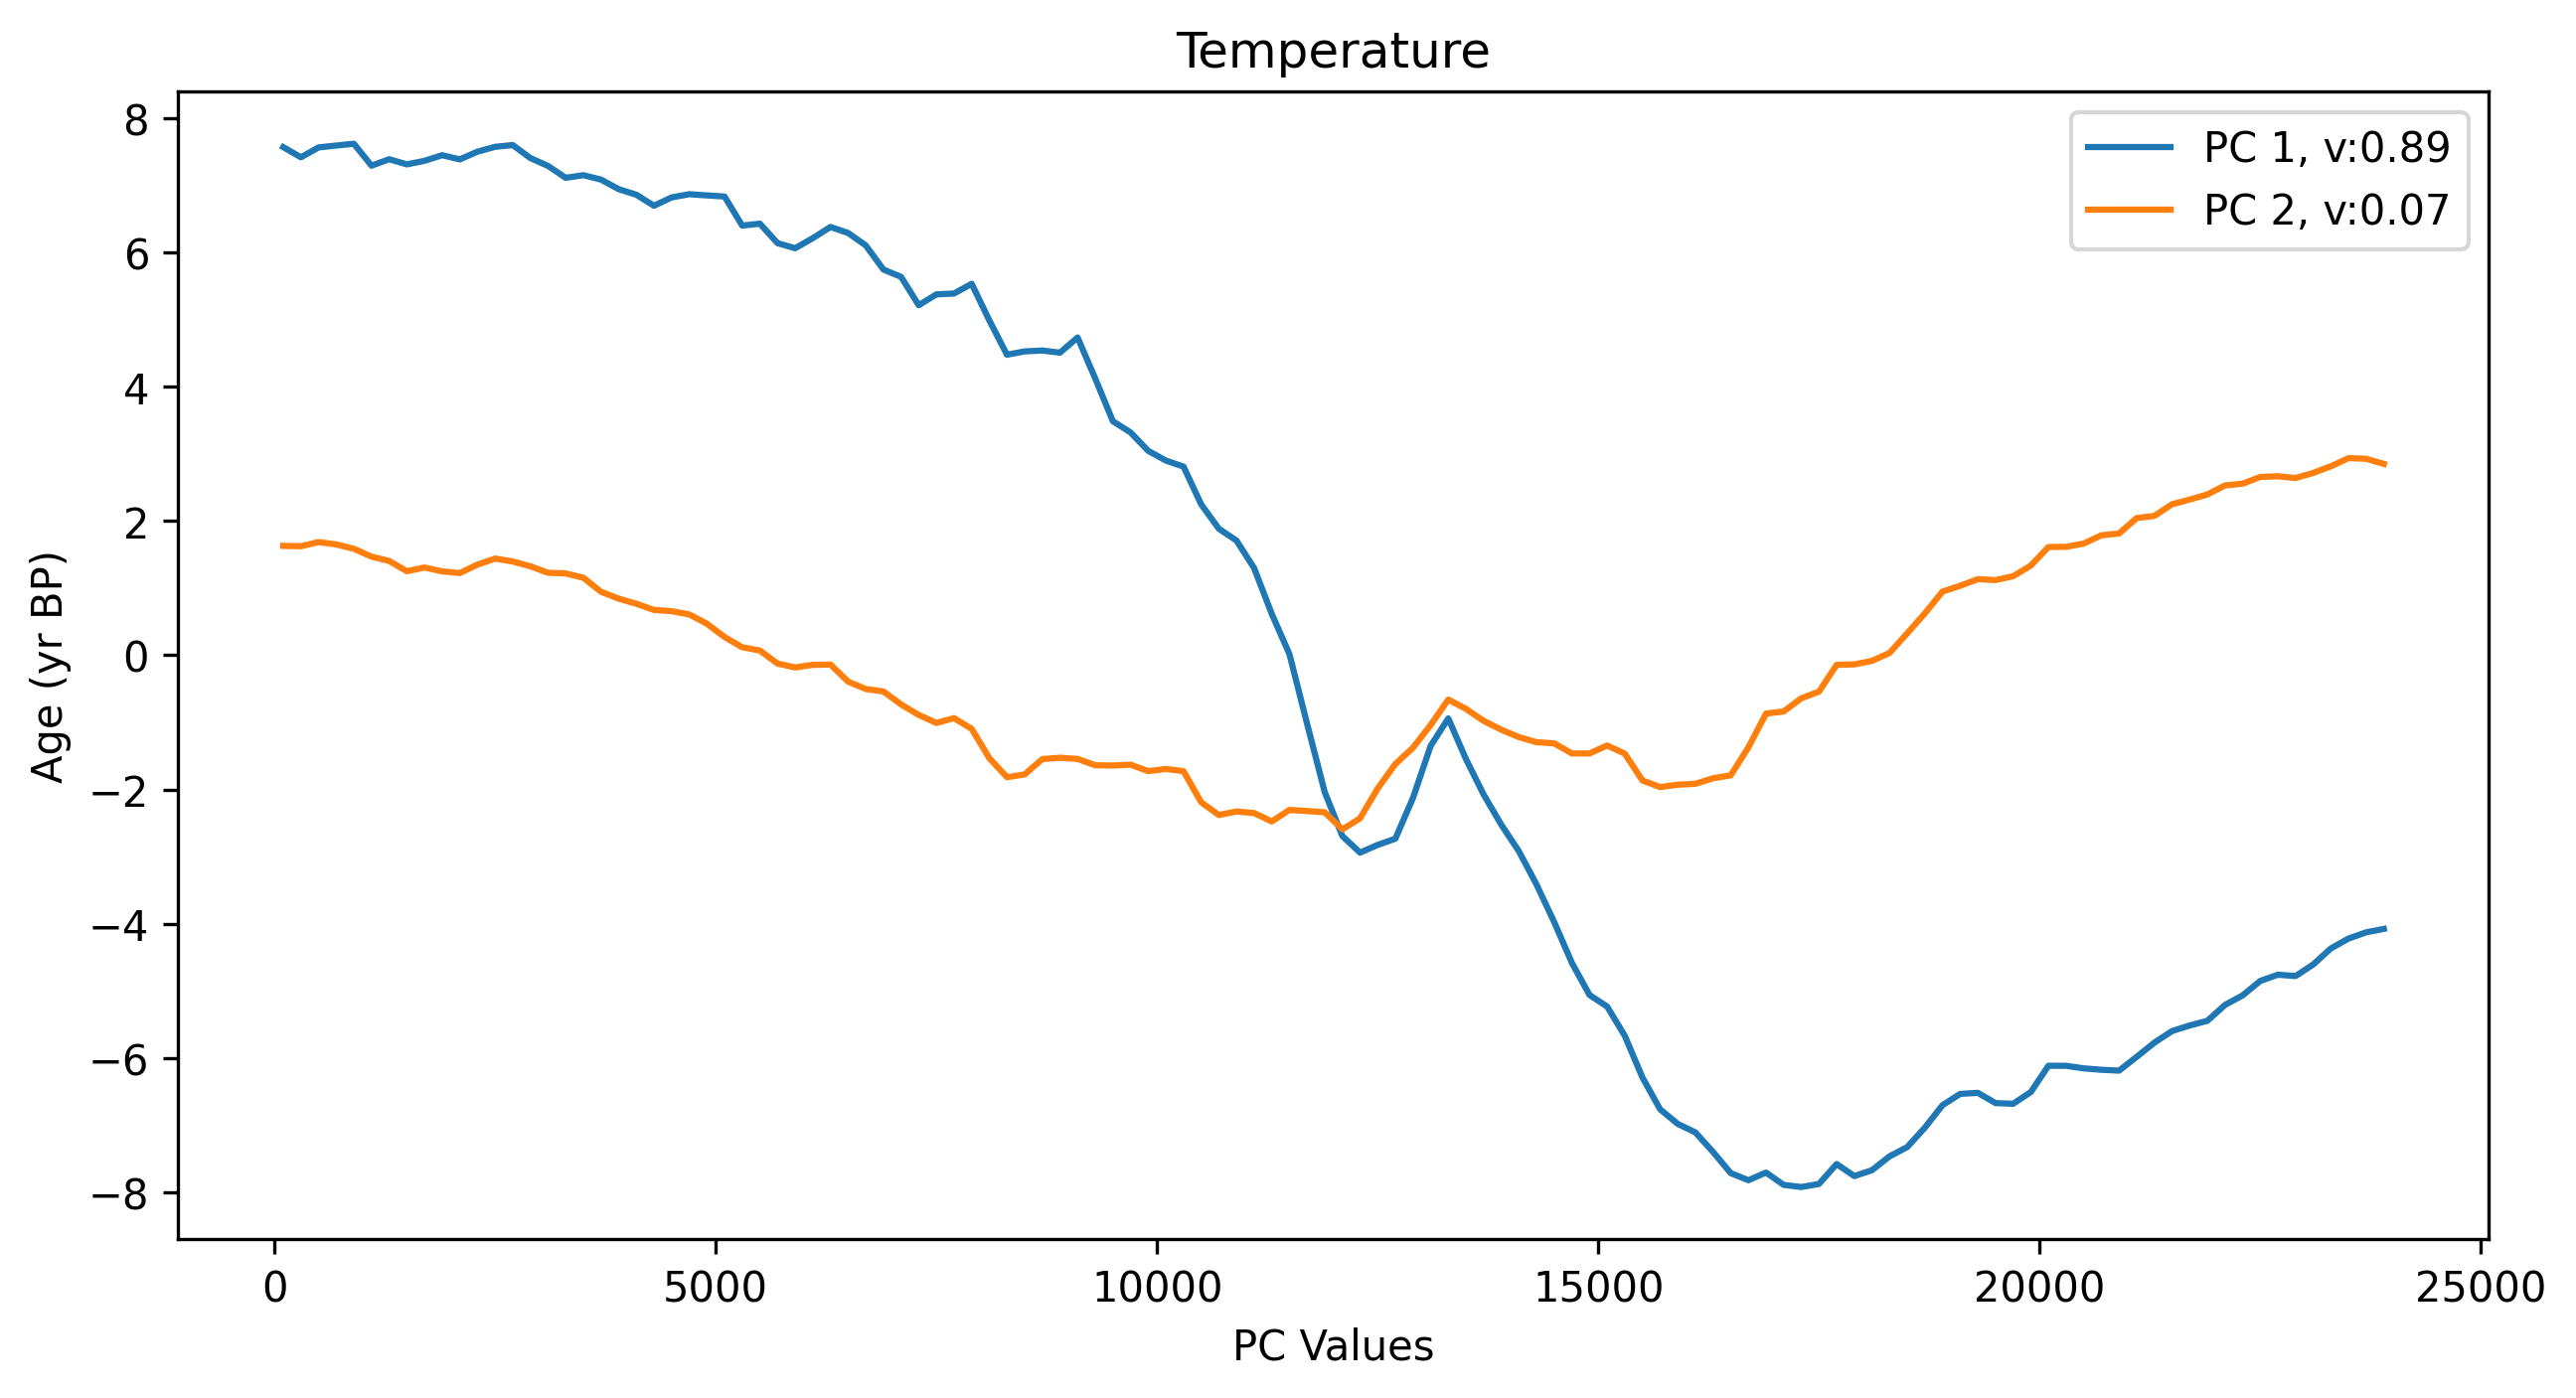

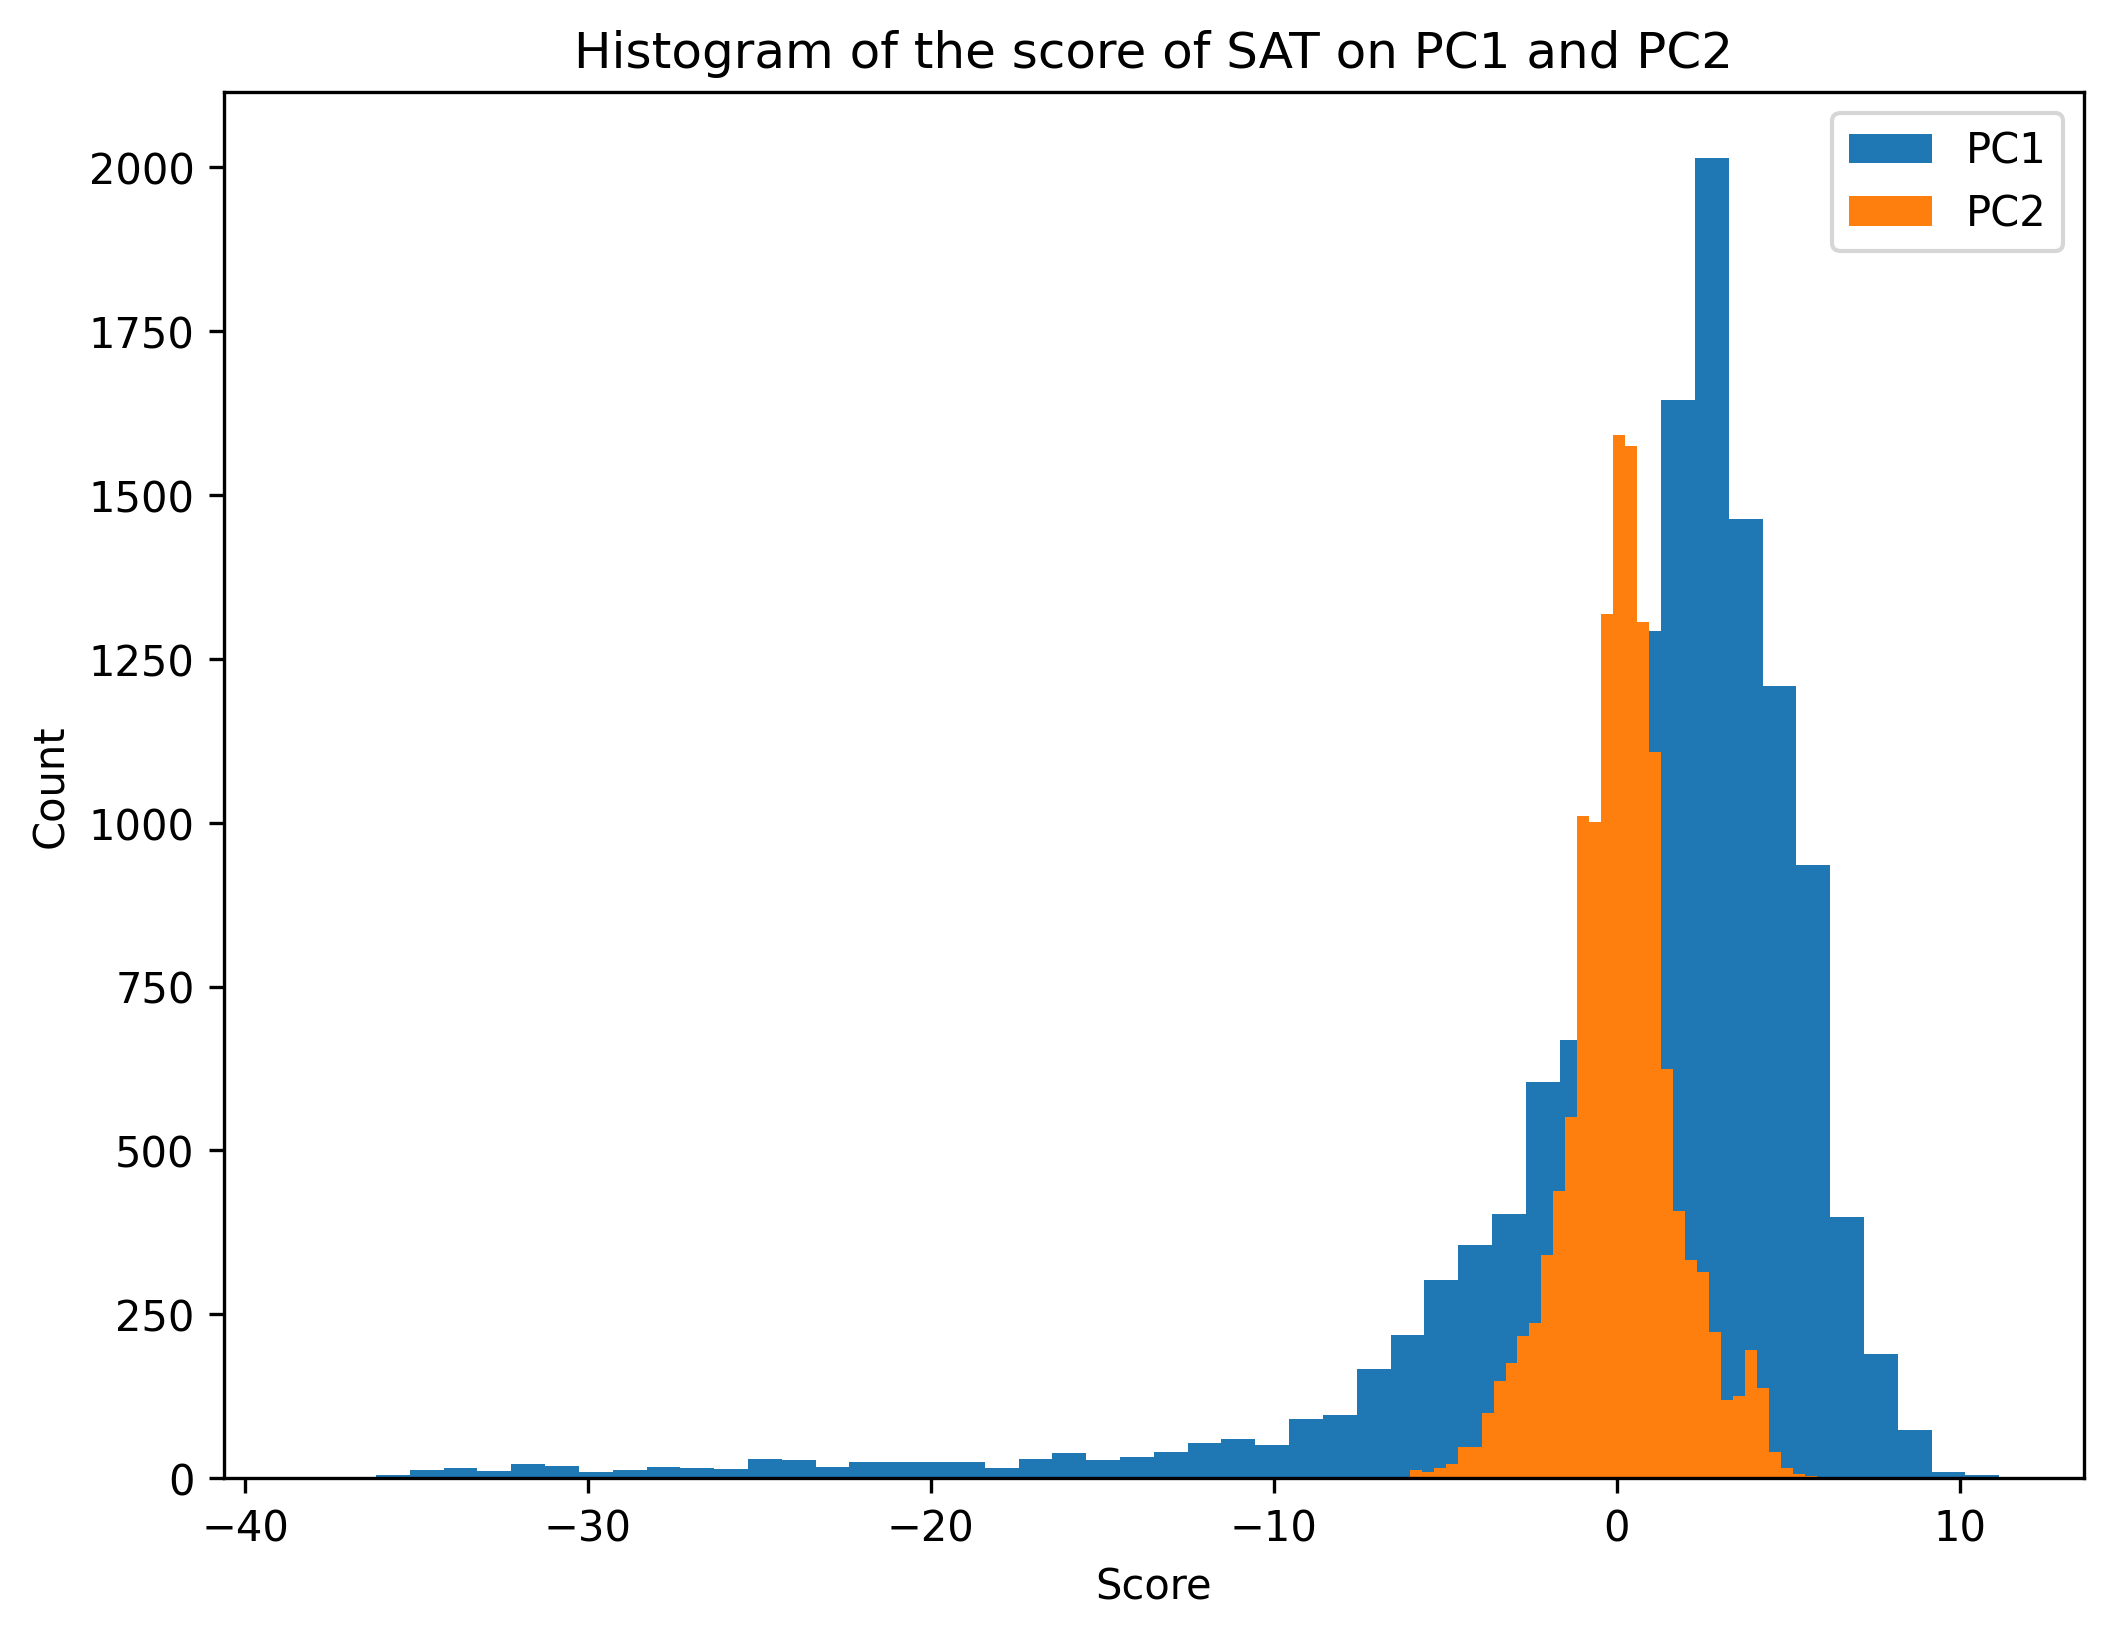

In [70]:
tem_score_spatial_normalized_centered_weighted_zscore=pca_score(sat_spatial_normalized_centered_weighted.T, ds_sat, n_pc=2, reversed=False, if_zscore=True)

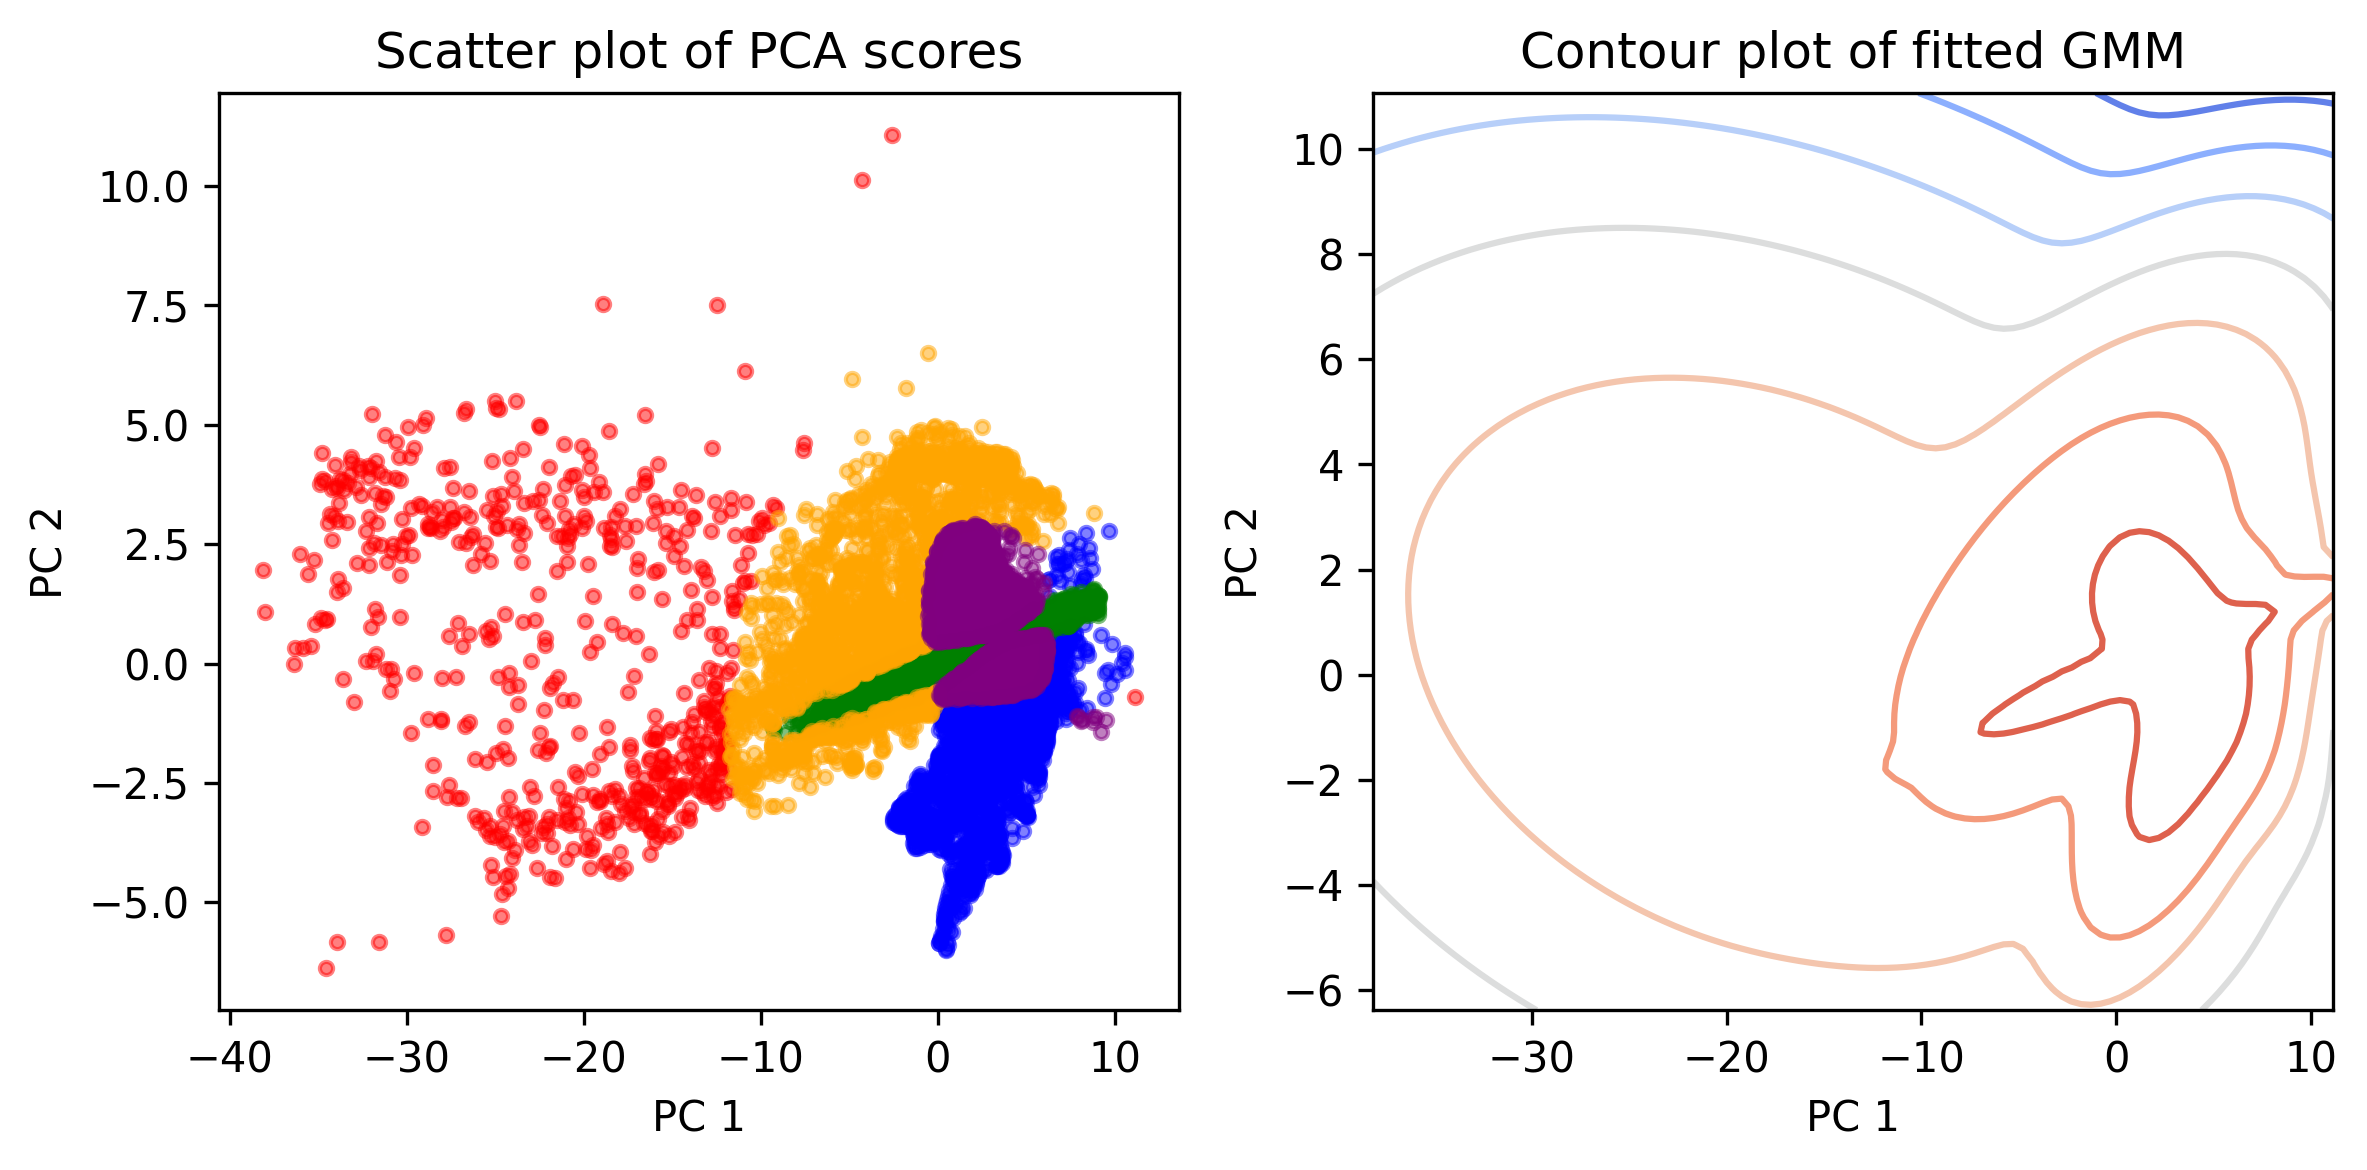

In [73]:
GMM_test(tem_score_spatial_normalized_centered_weighted_zscore, ds_sat, n_components=5)

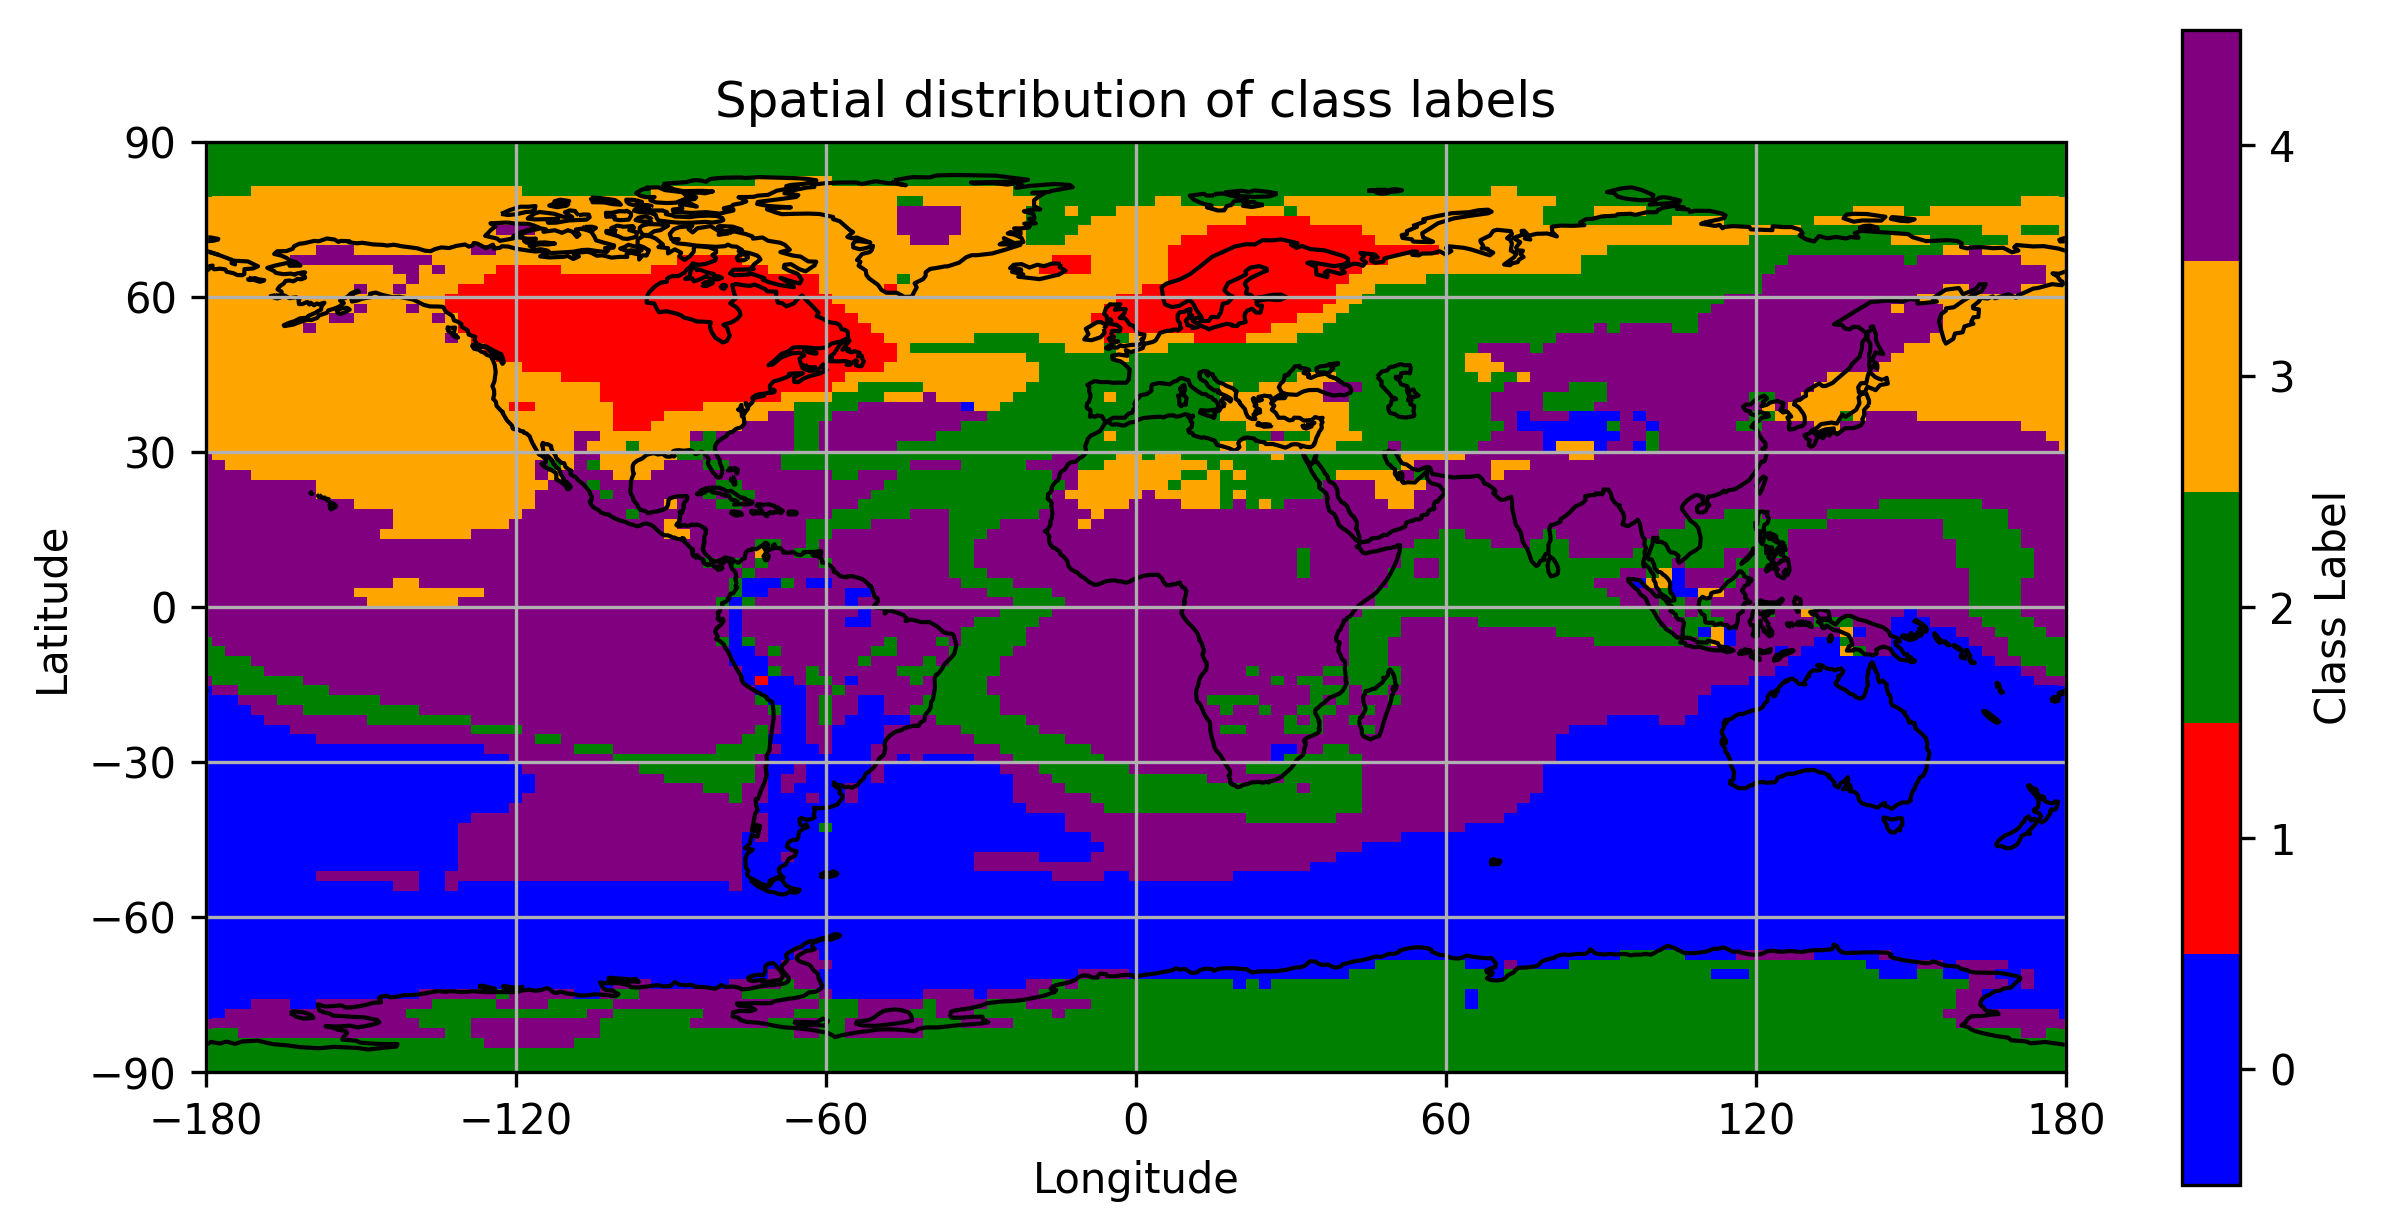

In [74]:
import GMM_functions as gf
gf.plot_labels(ds_sat)

variation explained by PC1 and PC2 for temperature: [0.9351734  0.03980673]


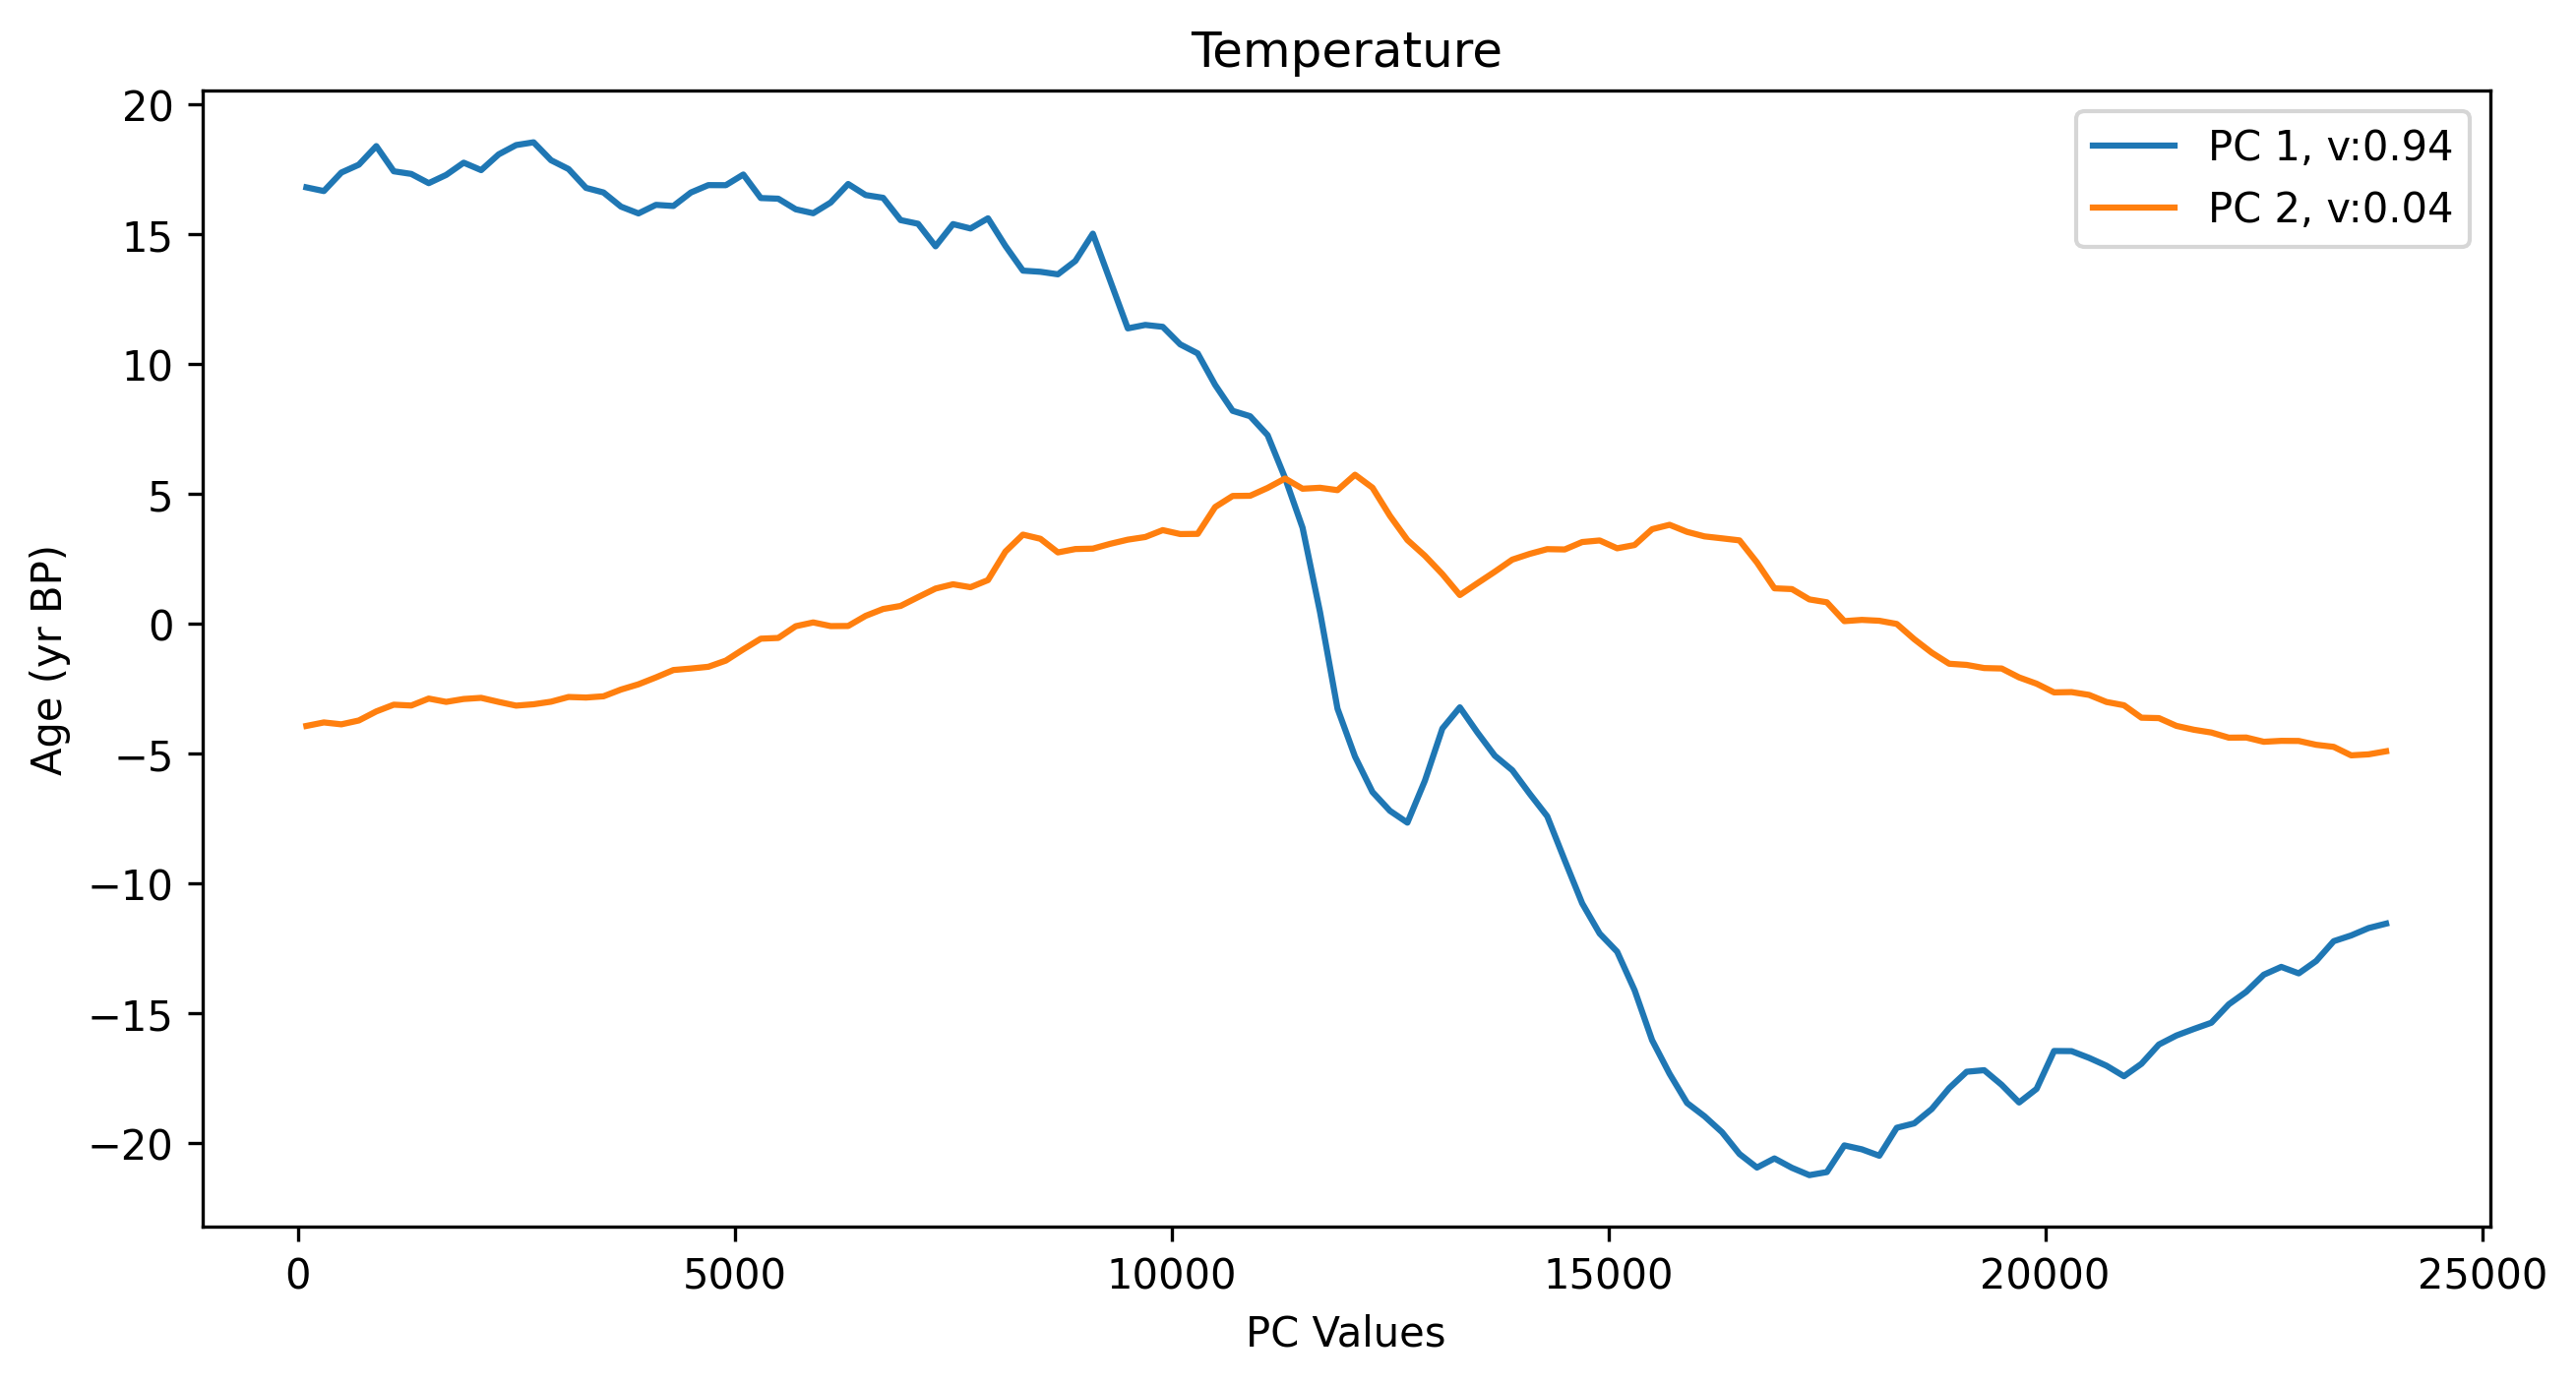

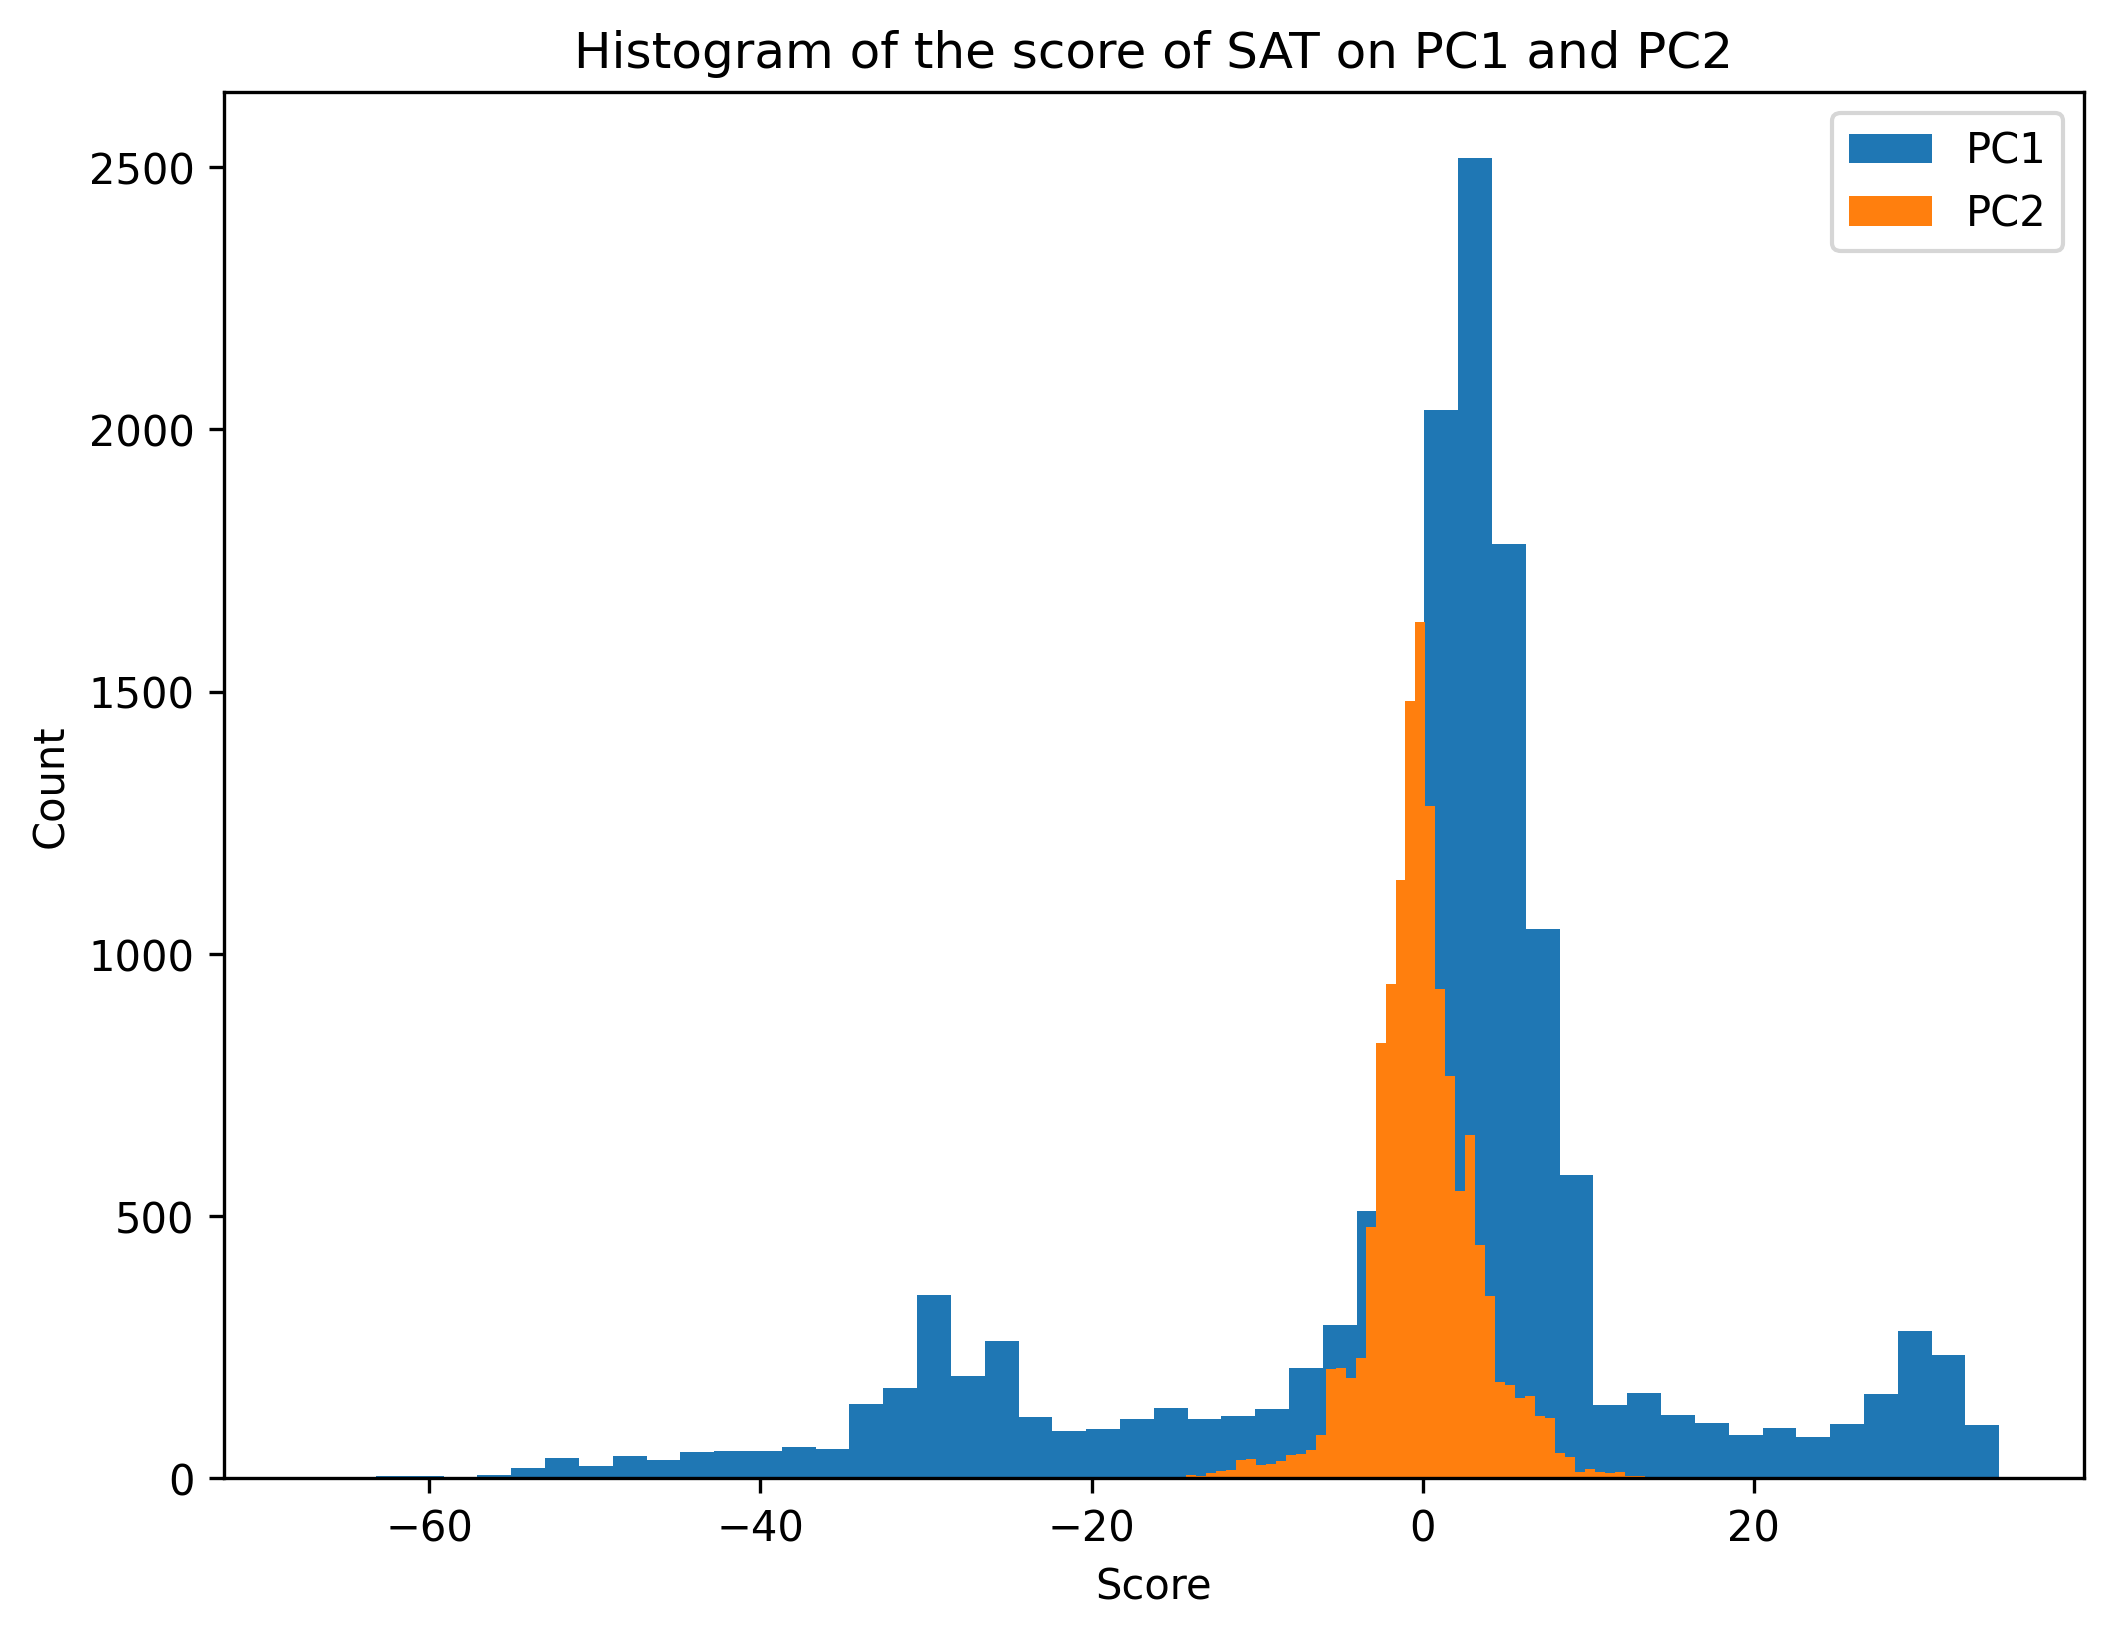

In [44]:
tem_score_spatial_normalized_zscore=pca_score(sat_spatial_normalized.T, ds_sat, n_pc=2, reversed=False, if_zscore=True)

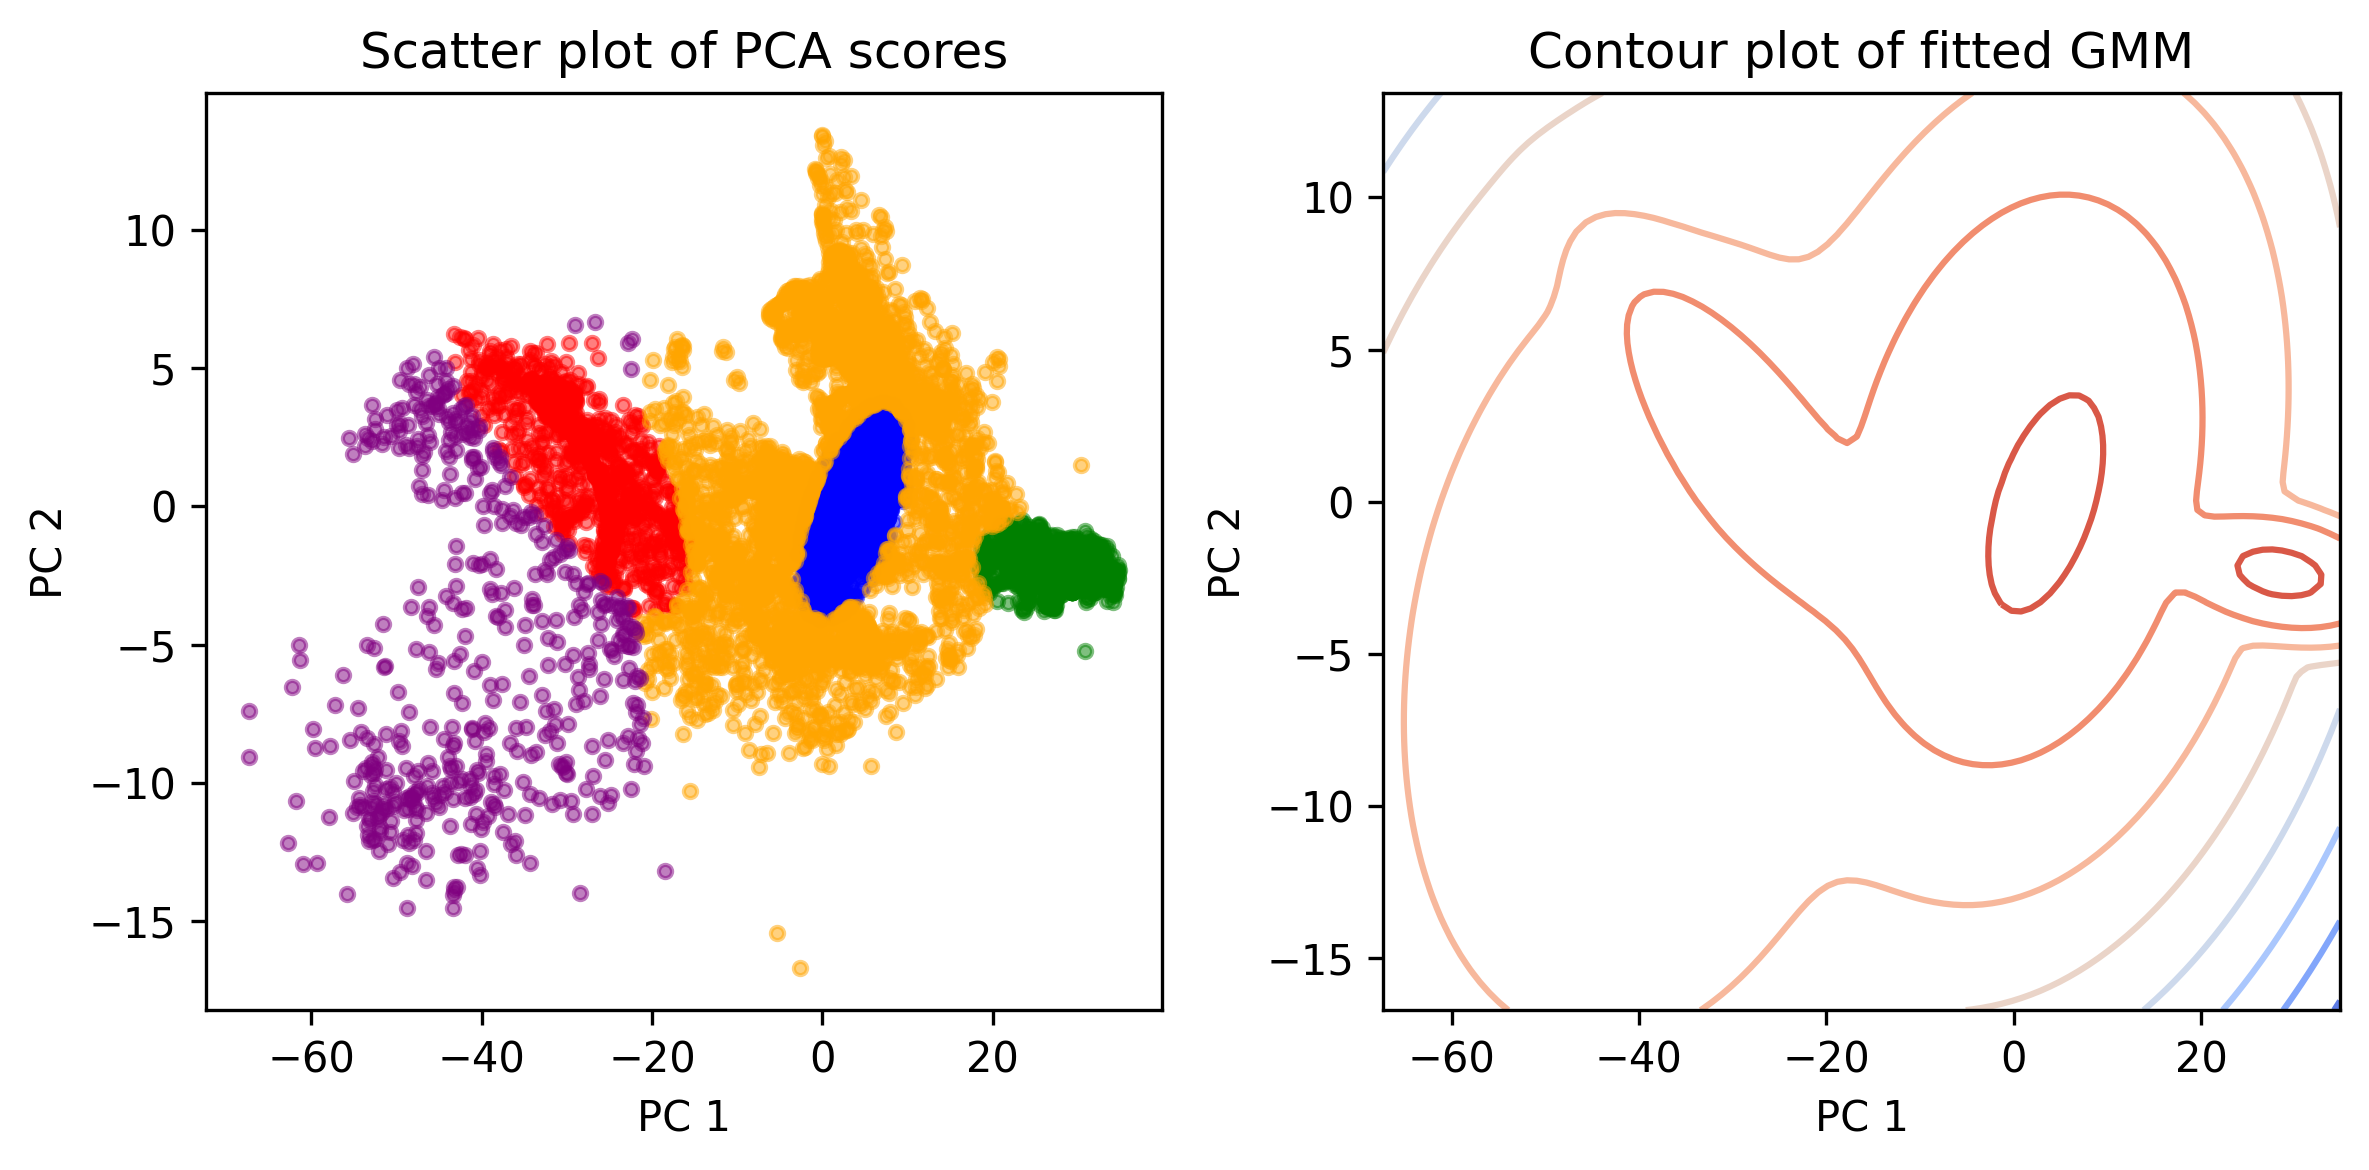

In [45]:
GMM_test(tem_score_spatial_normalized_zscore, ds_sat, n_components=5)

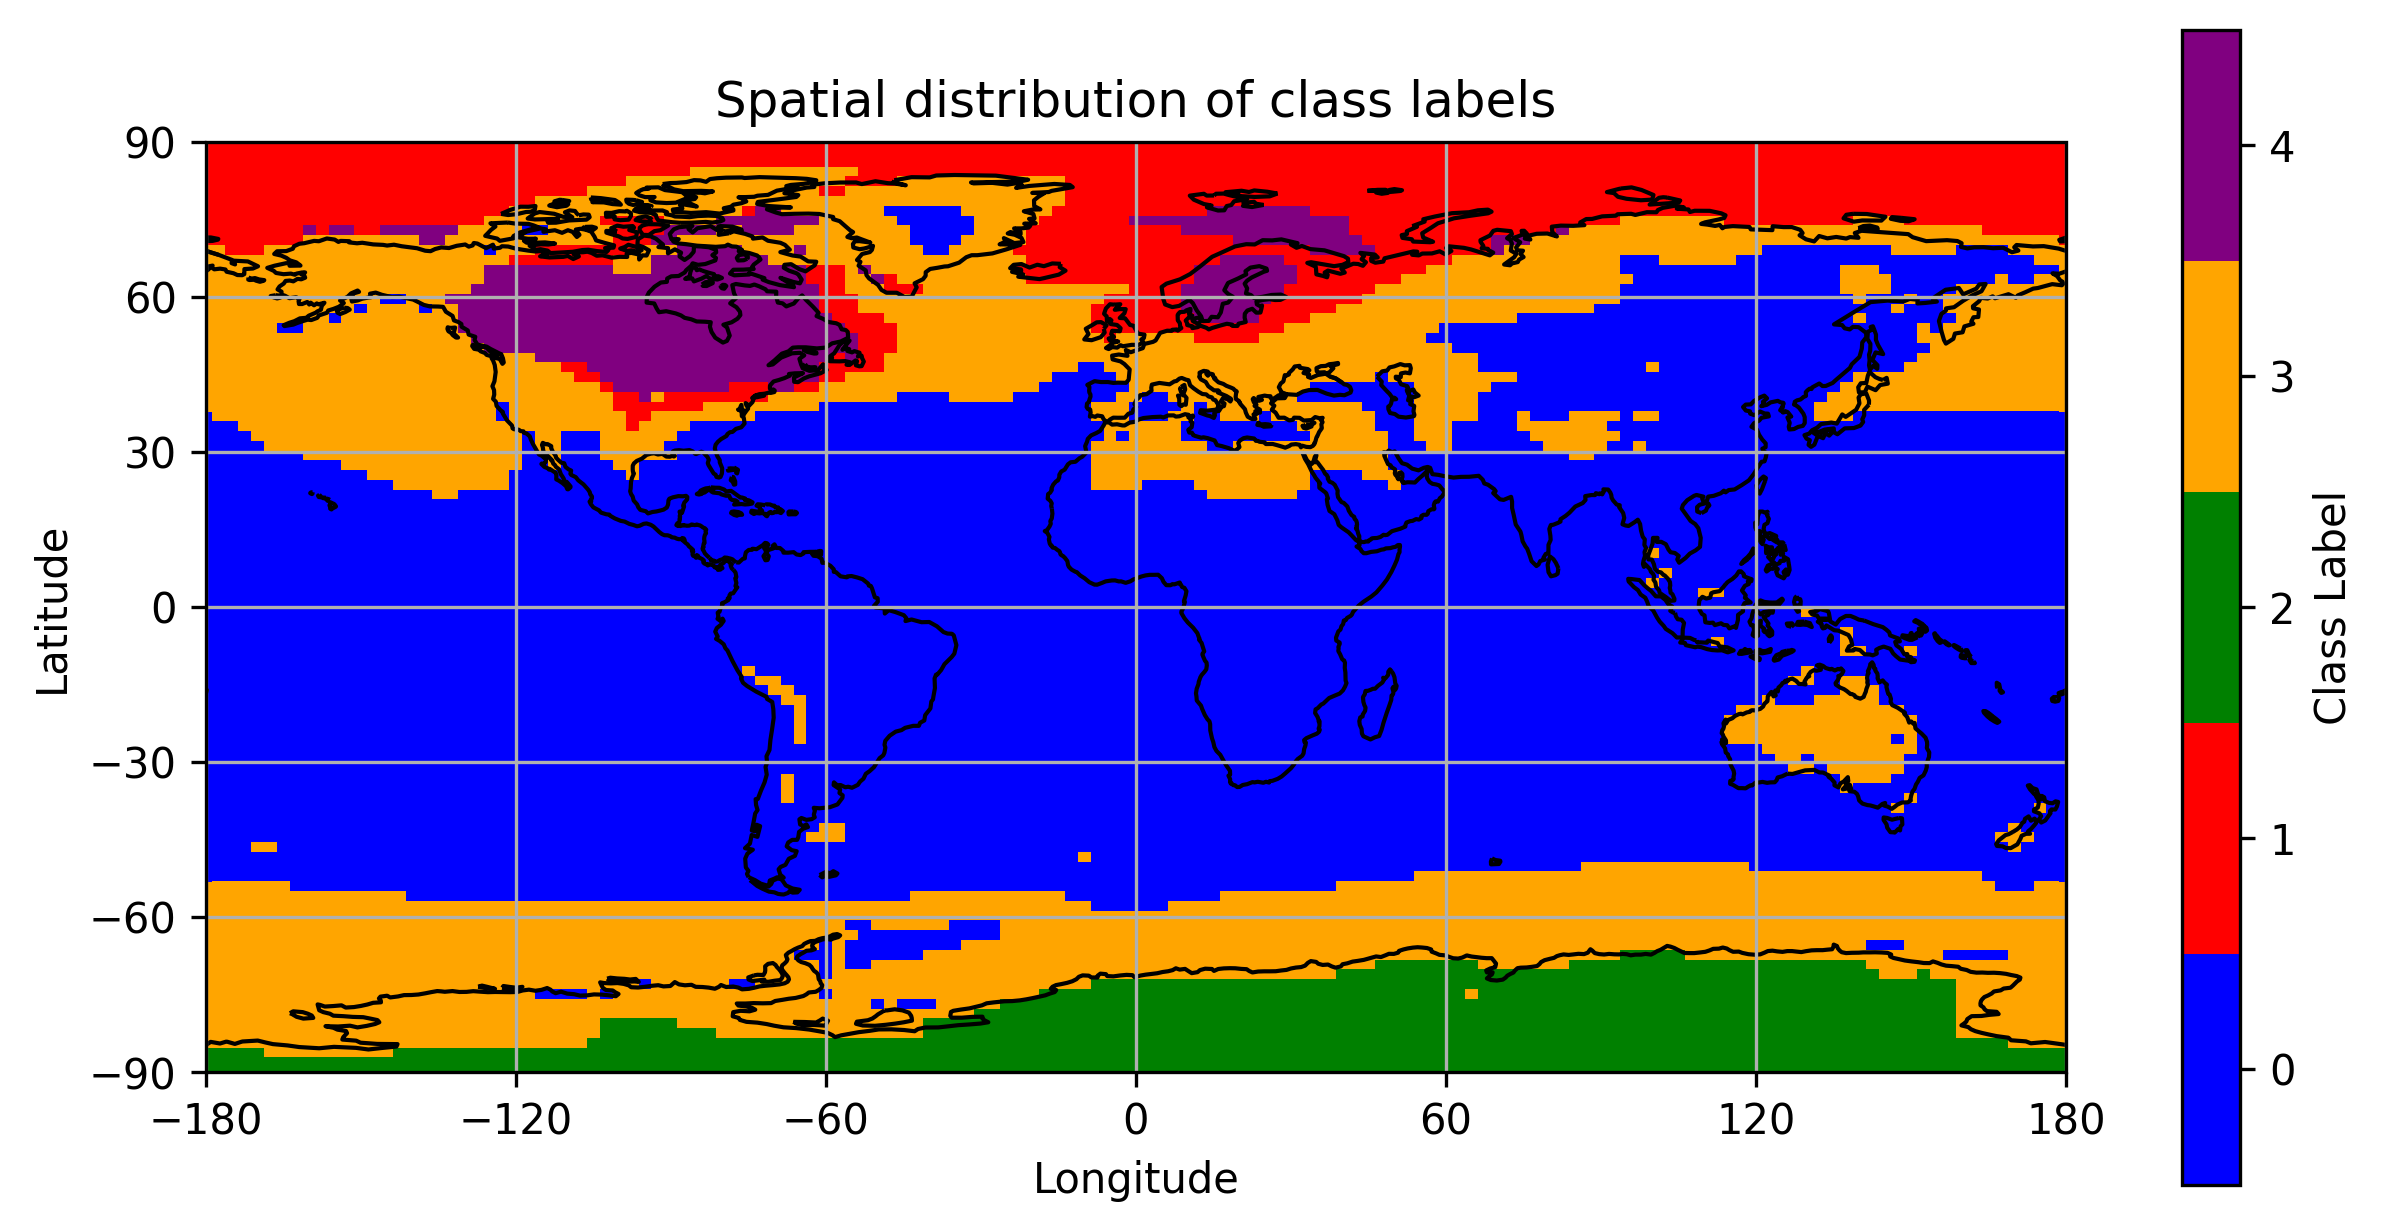

In [46]:
import GMM_functions as gf
gf.plot_labels(ds_sat)

variation explained by PC1 and PC2 for temperature: [0.9351736  0.03980673]


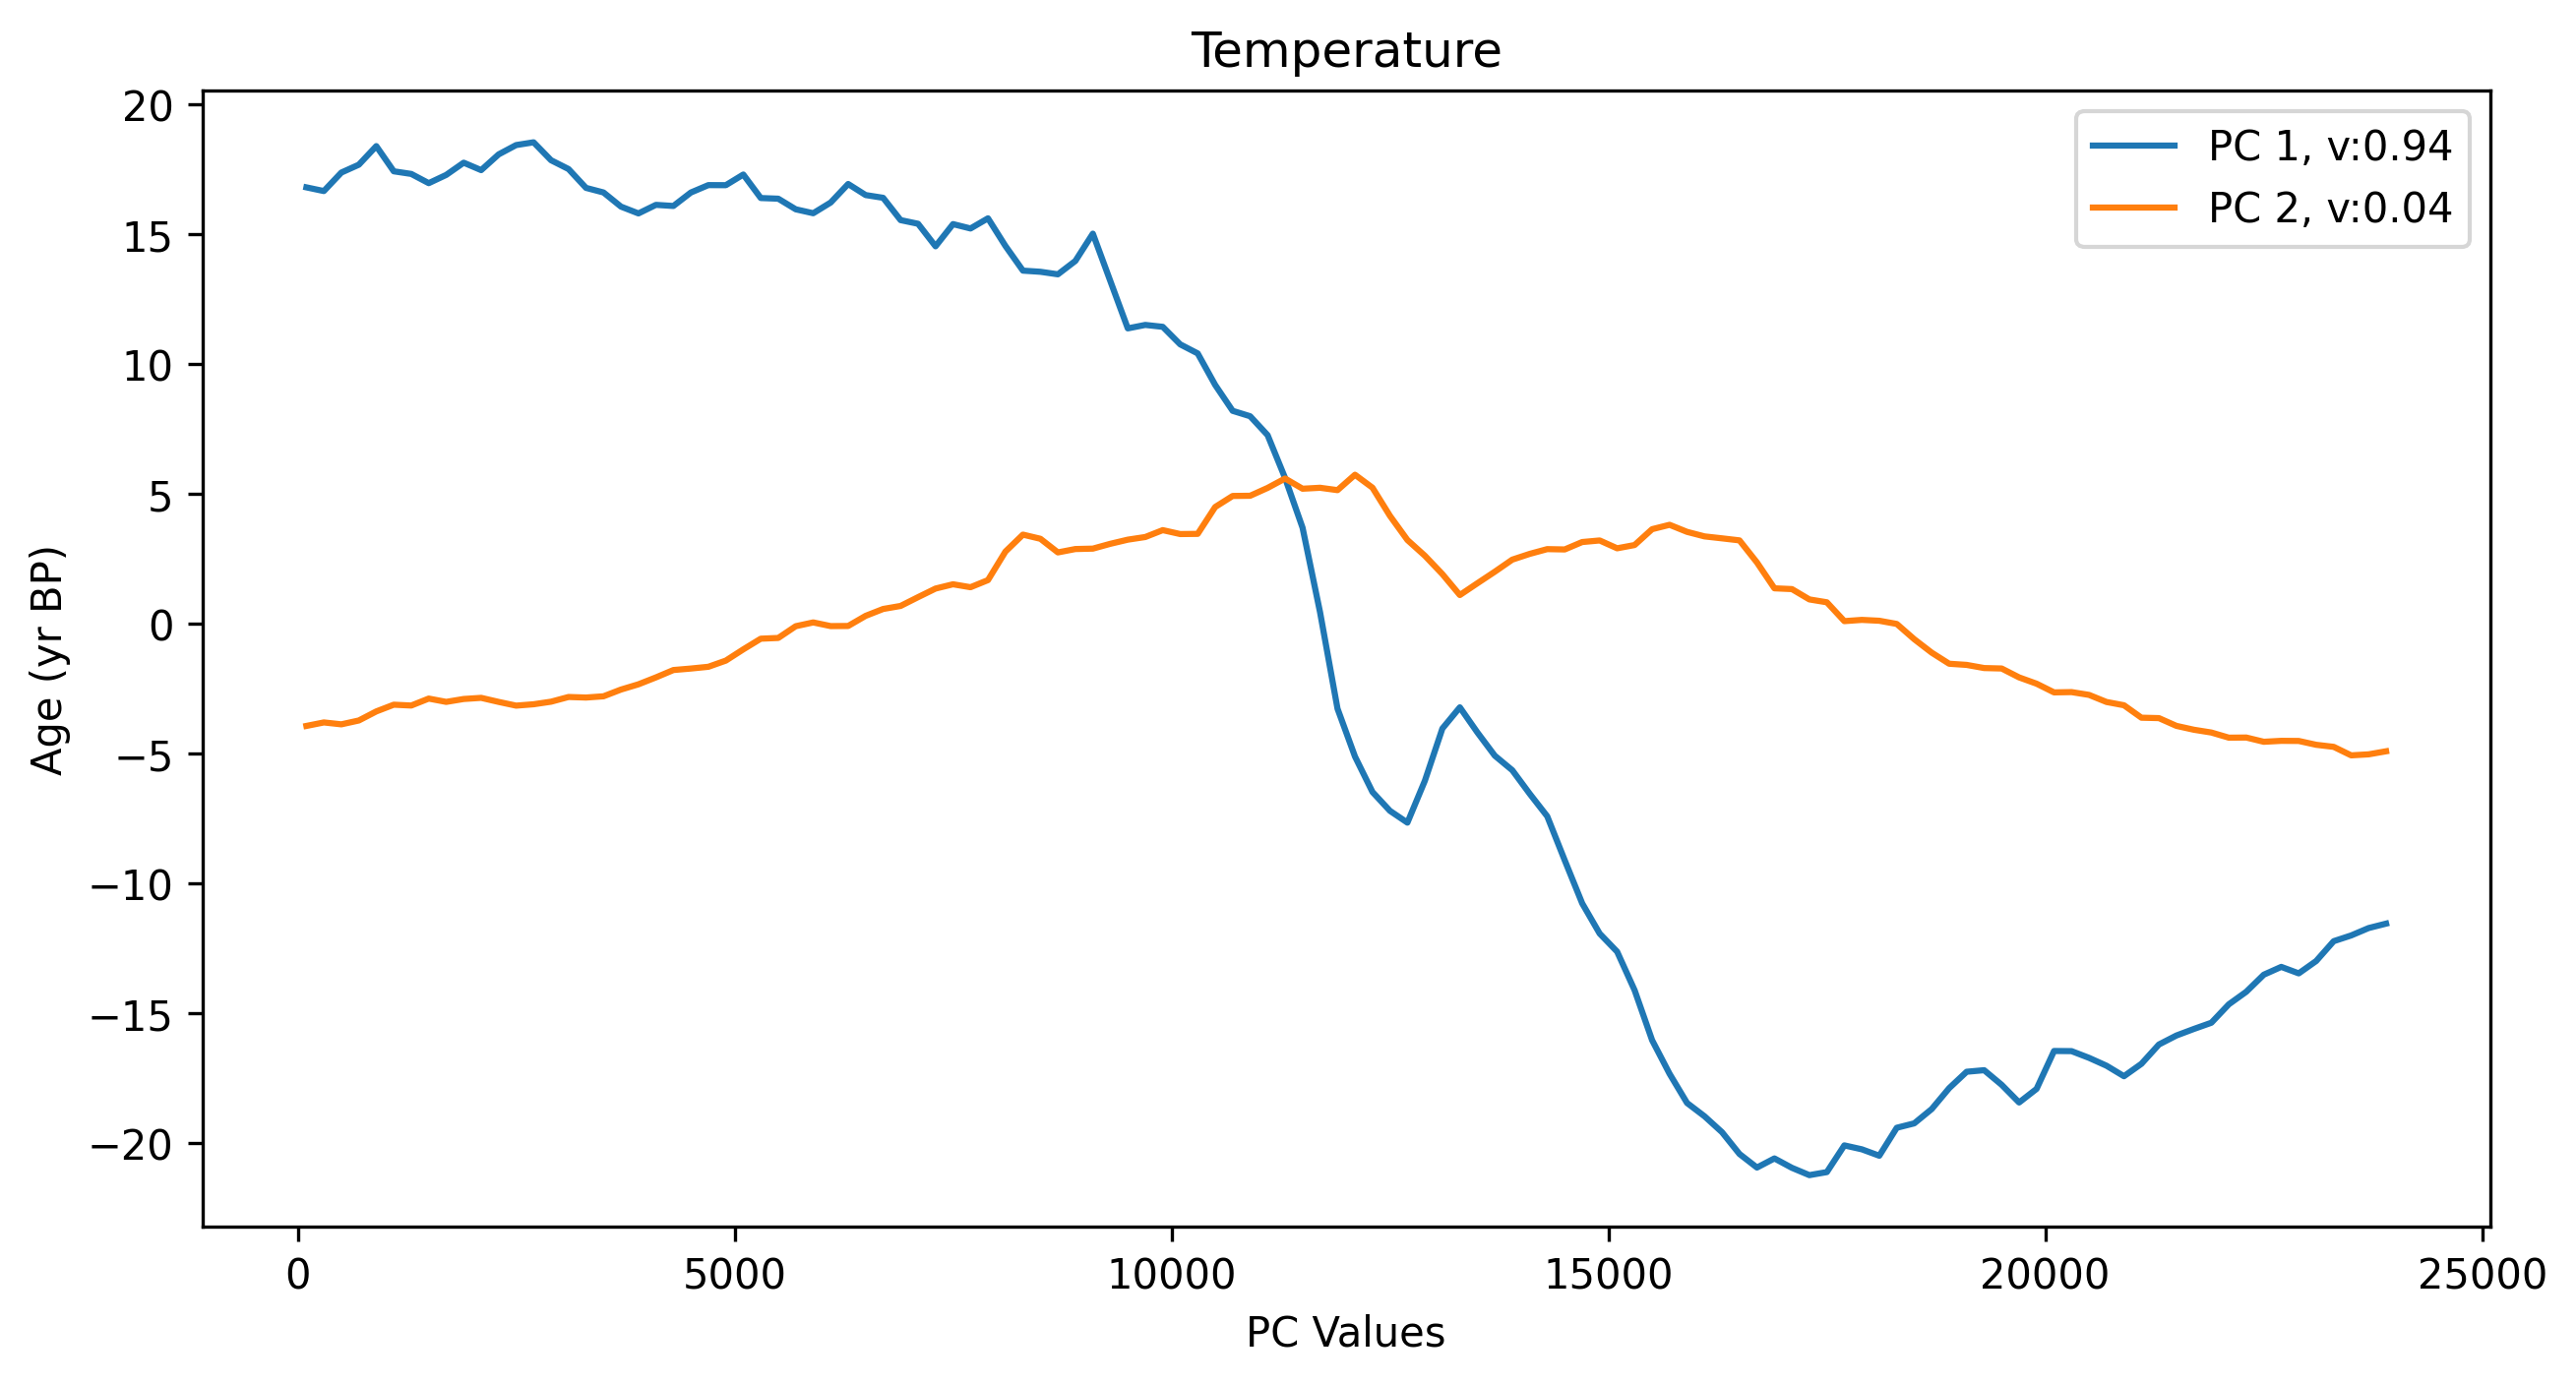

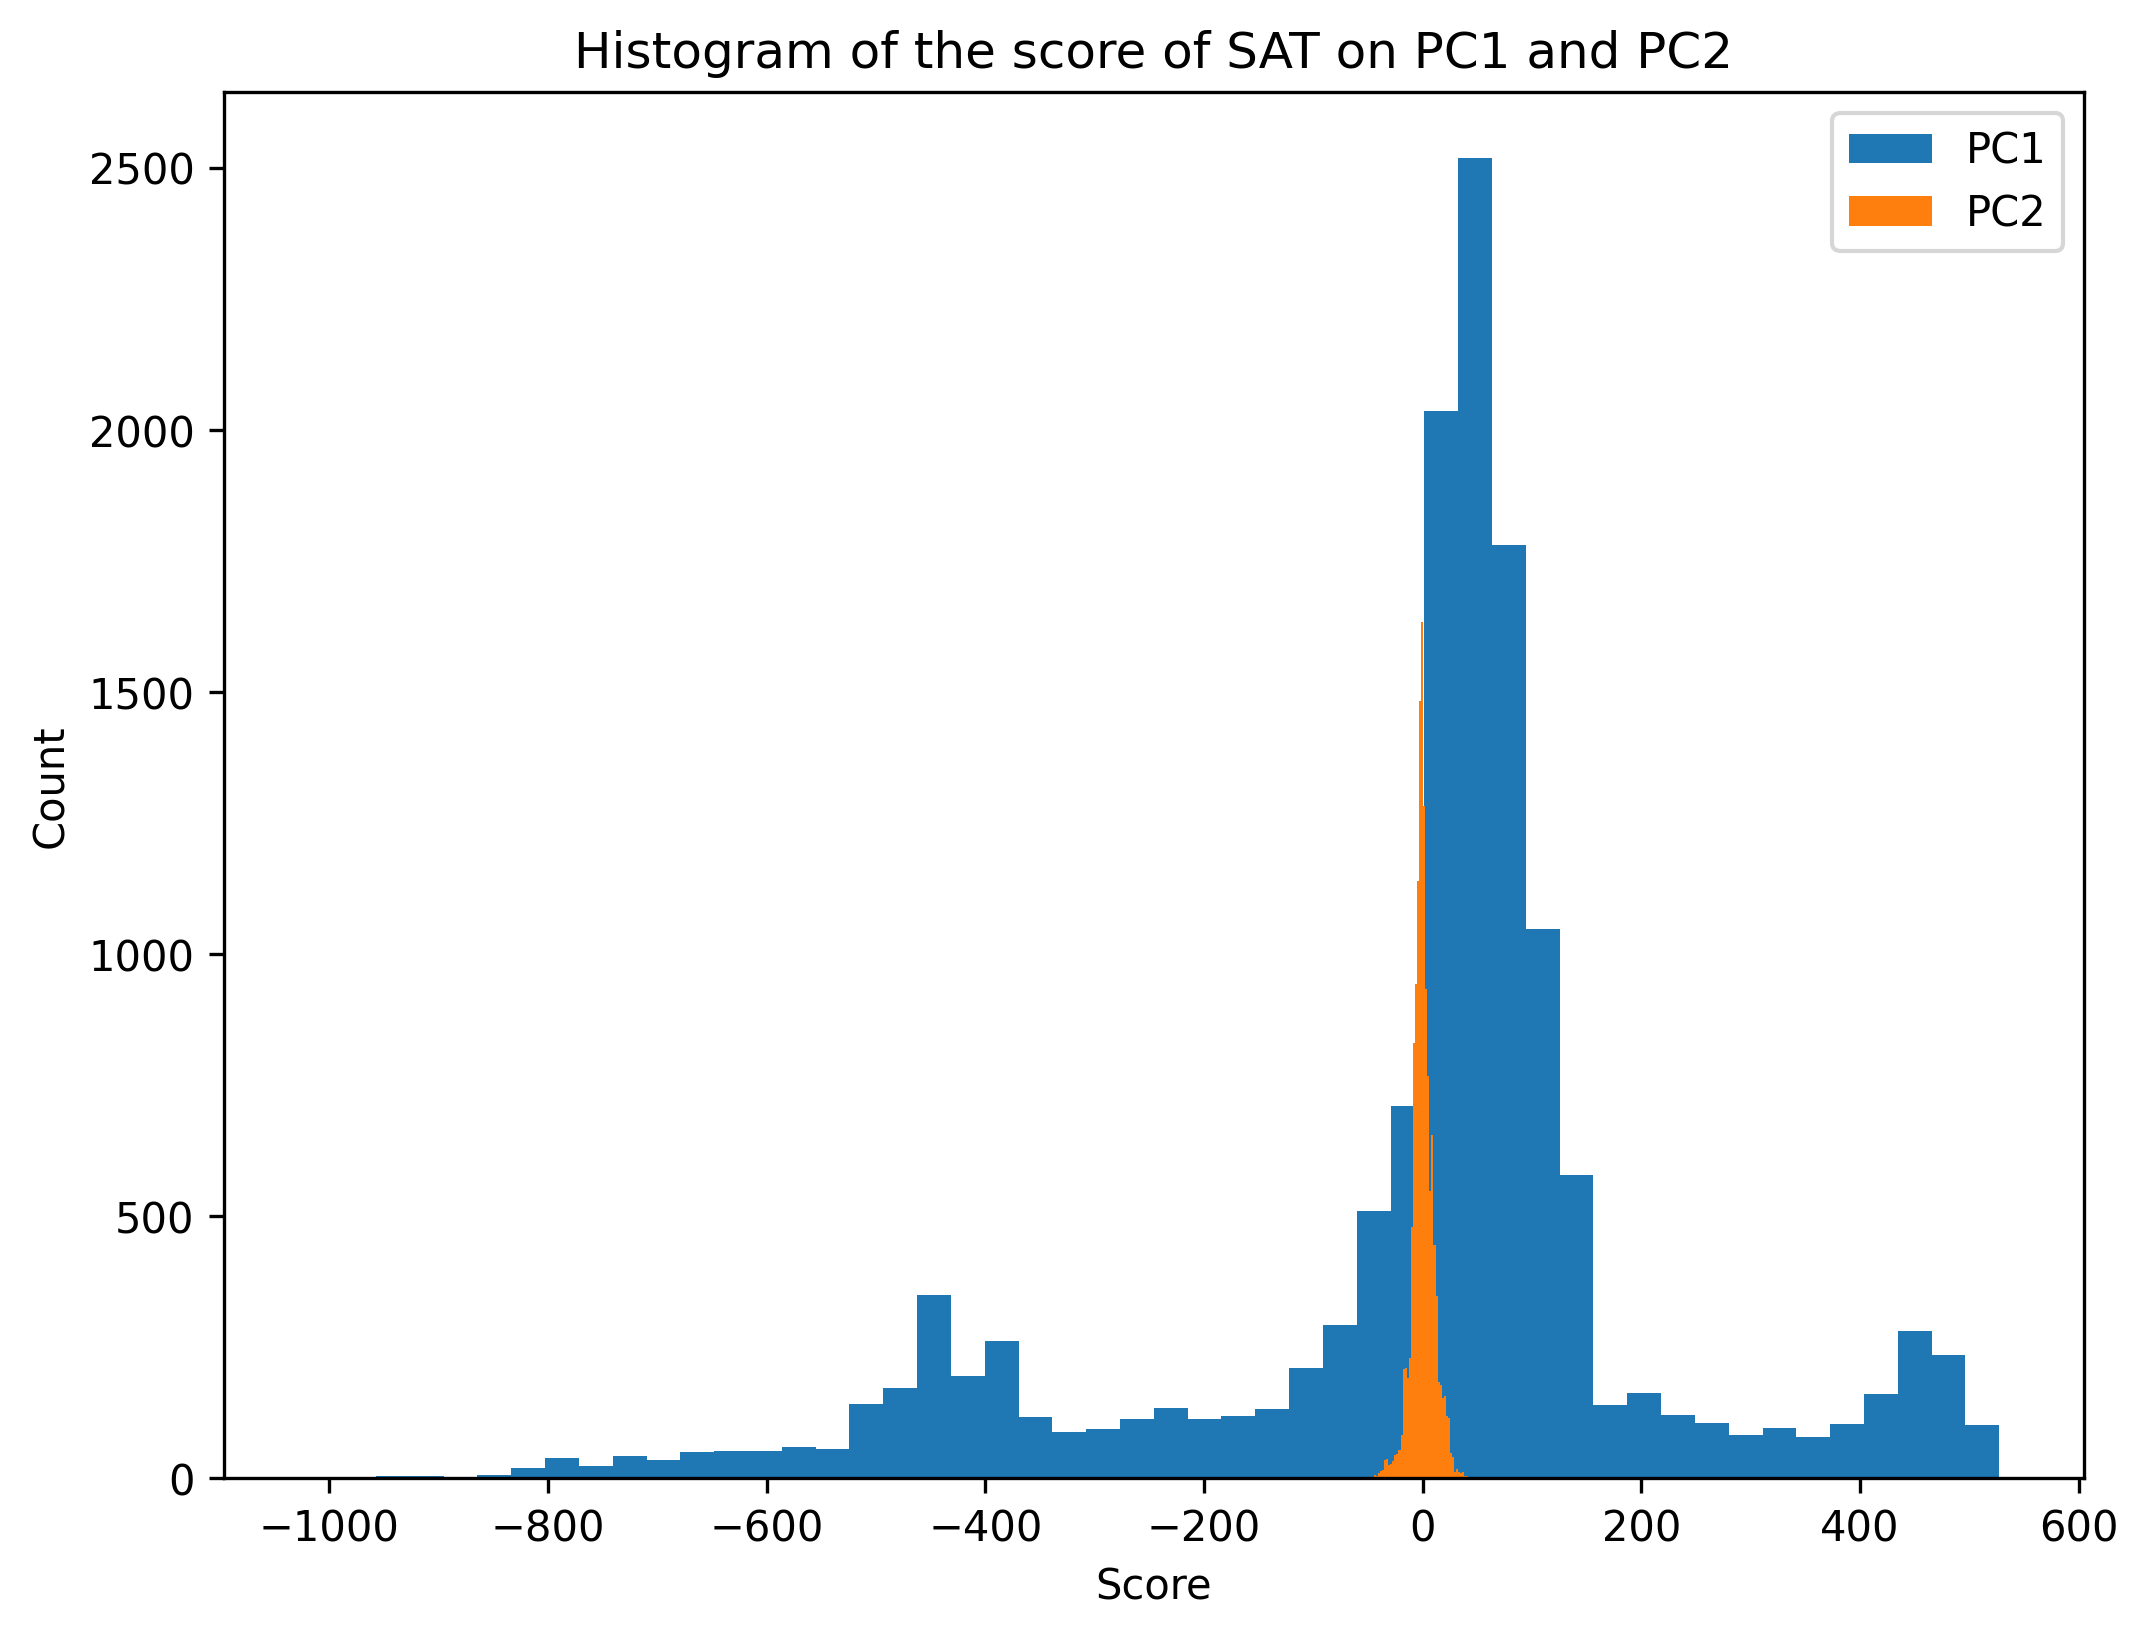

In [75]:
tem_score_spatial_normalized_no_zscore=pca_score(sat_spatial_normalized.T, ds_sat, n_pc=2, reversed=False, if_zscore=False)

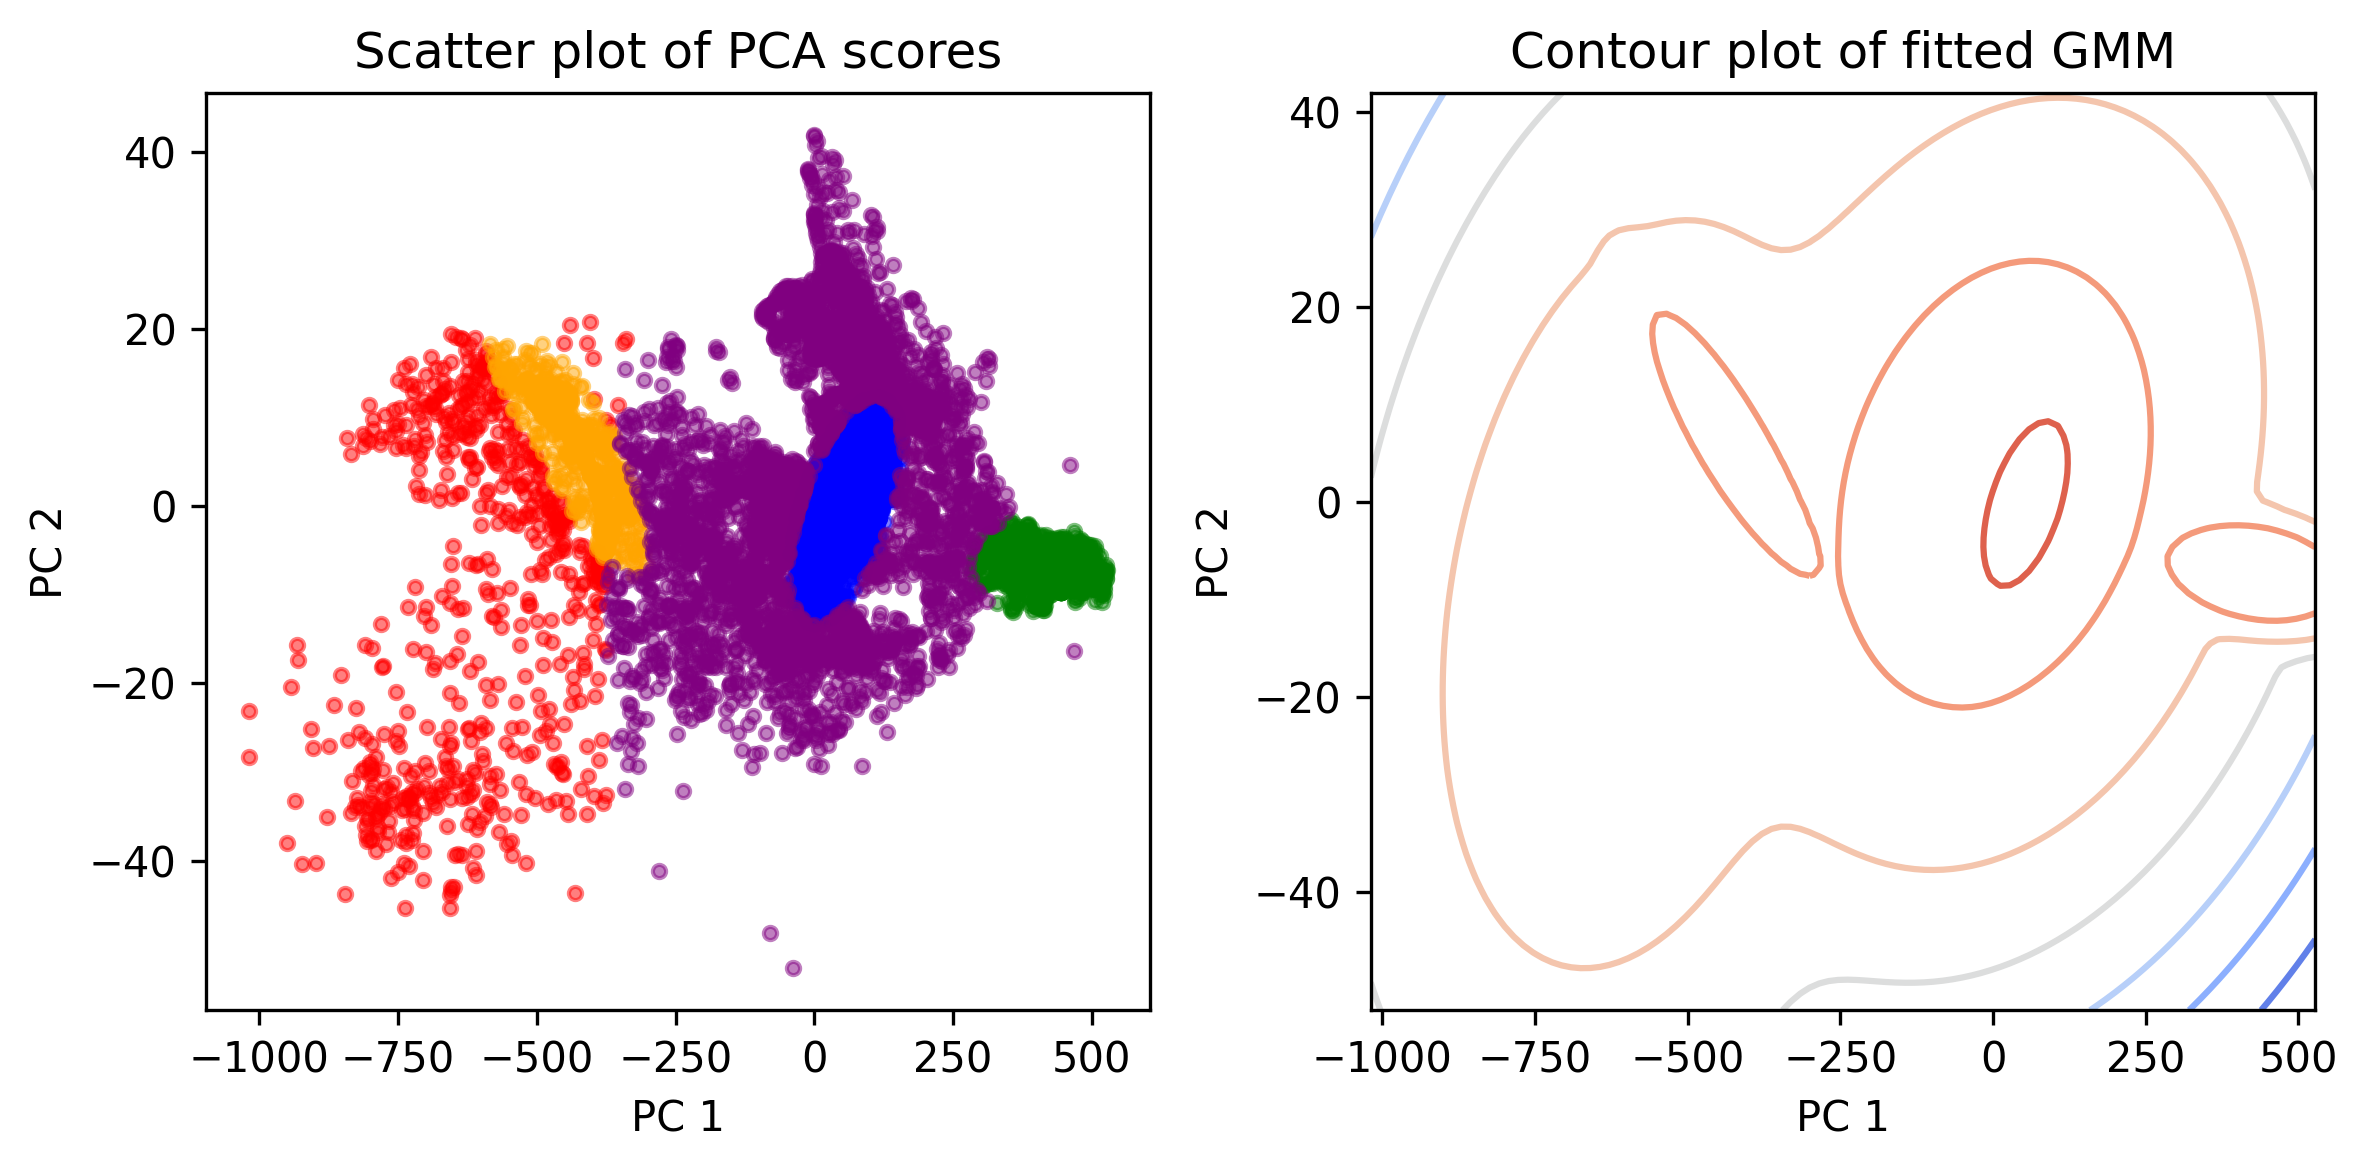

In [76]:
GMM_test(tem_score_spatial_normalized_no_zscore, ds_sat, n_components=5)

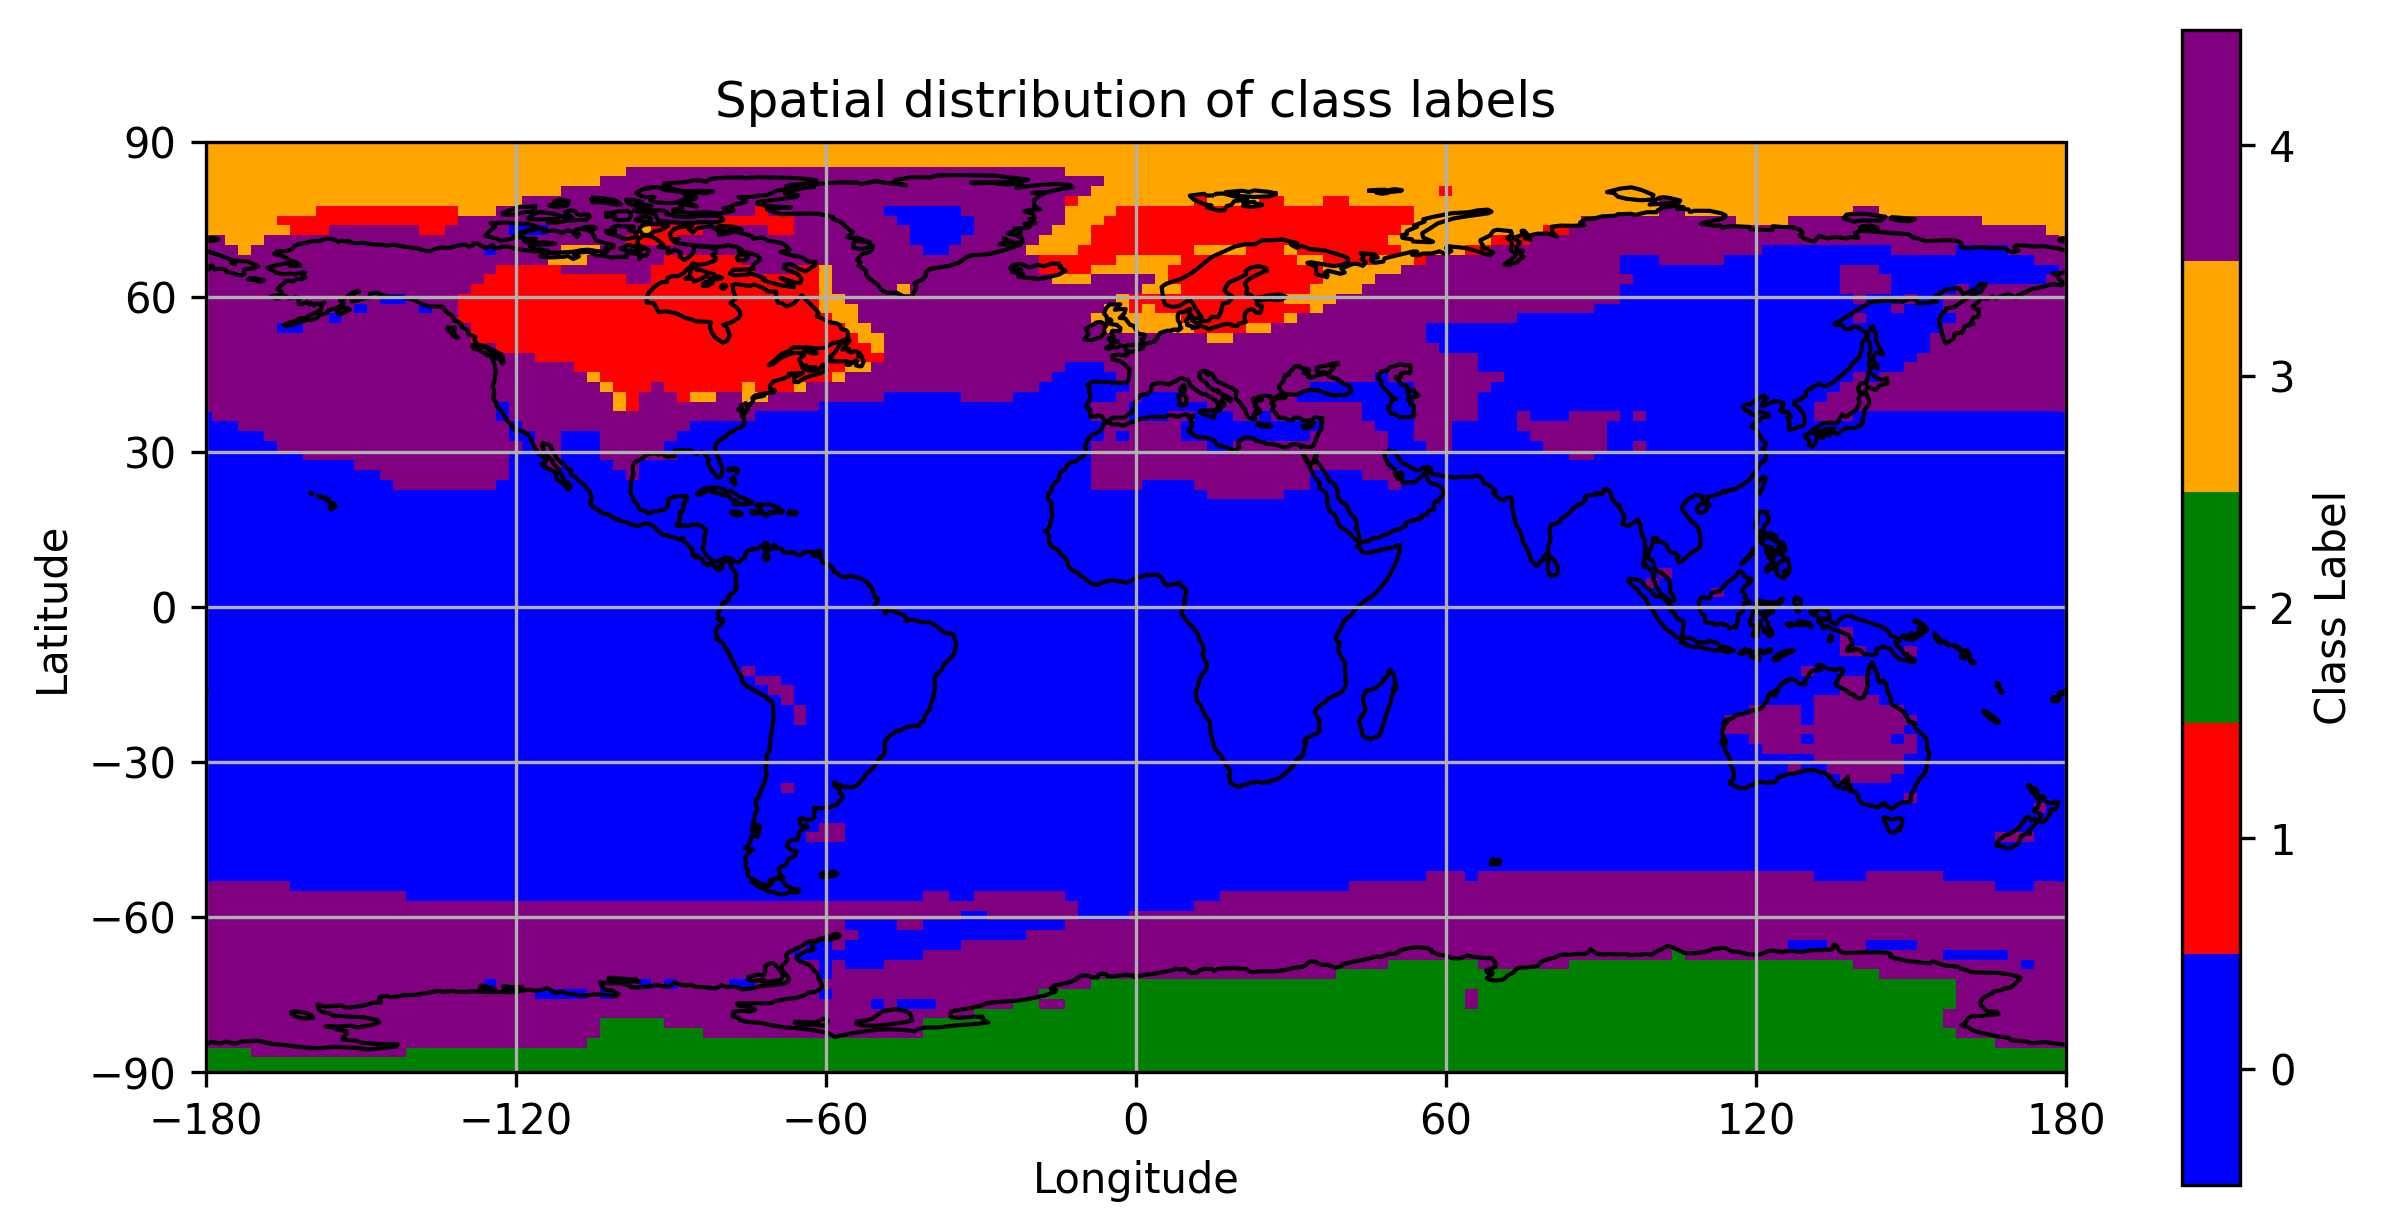

In [77]:
import GMM_functions as gf
gf.plot_labels(ds_sat)